In [1]:
import apogee.tools.read as apread
from apogee.tools import _aspcapPixelLimits
from apogee.tools.path import change_dr
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as afits
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from apogee.tools import bitmask as bm
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN
from gaia_tools import load as gload
from gaia_tools import xmatch as gmatch
import scipy.misc as sm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib.colors import LogNorm
default_cmap='viridis'
fs = 12
import matplotlib
font = {'family': 'serif',
        'weight': 'normal',
        'size'  :  fs
}

matplotlib.rc('font',**font)
def histogram2d(fig,ax,x,y,bins=100,clabel=False,vmin=0,vmax=110,norm='lin'):
    """
    Create a 2D histogram of data represented by the two dimensions x and y
    
    fig:      Figure to plot in
    ax:       Subplot object to plot in
    x:        Array of data values in 'x'
    y:        Array of data values in 'y'
    bins:     Number of bins in which to divide each axis
    clabel:   Label for the colourbar - no colourbar is plotted if this is not given
    vmin:     Minimum value of the histogram
    vmax:     Maximum value of the histogram
    
    """
    # Create histogram
    H,xedges,yedges = np.histogram2d(x,y,bins=bins)
    # Reorient appropriately
    H = np.rot90(H)
    H = np.flipud(H)
    # Mask where bins are empty
    Hmasked = np.ma.masked_where(H==0,H)
    # Plot histogram
    if norm == 'lin':
        im = ax.pcolormesh(xedges,yedges,Hmasked,
                           cmap = plt.get_cmap(default_cmap),
                           vmin=vmin,vmax=vmax)
    elif norm == 'log':
            im = ax.pcolormesh(xedges,yedges,Hmasked,
                           cmap = plt.get_cmap(default_cmap),
                           norm=LogNorm(vmin=vmin,vmax=vmax))
    # If colourbar is desired, plot and label it
    if clabel:
        cbar=fig.colorbar(im,pad = 0)
        cbar.set_label(label=clabel,fontsize=fs)
        cbar.ax.tick_params(labelsize=fs)
    elif not clabel:
        cbar=fig.colorbar(im,pad = 0)
        cbar.ax.tick_params(labelsize=fs)

In [3]:
change_dr('13')
pixels = _aspcapPixelLimits()[-1]

In [4]:
apogee_cat = apread.allStar(rmdups=True)

In [5]:
g2match, matches_indx= gmatch.cds(apogee_cat,xcat='vizier:I/345/gaia2') 
apogee_cat= apogee_cat[matches_indx] 

In [6]:
goodparallax = np.where((g2match['parallax_error']/g2match['parallax']<=0.2) & (g2match['parallax']>0))

/home/price-jones/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [7]:
g2 = g2match[goodparallax]
apo = apogee_cat[goodparallax]

In [8]:
c = SkyCoord(ra=g2['ra']*u.degree,dec=g2['dec']*u.degree,
             distance=(1./g2['parallax'])*u.kpc,frame='icrs')
cgal = c.galactocentric
cgal.representation_type = 'cylindrical'

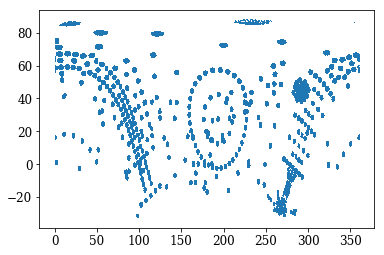

In [9]:
plt.plot(g2['ra'],g2['dec'],',')

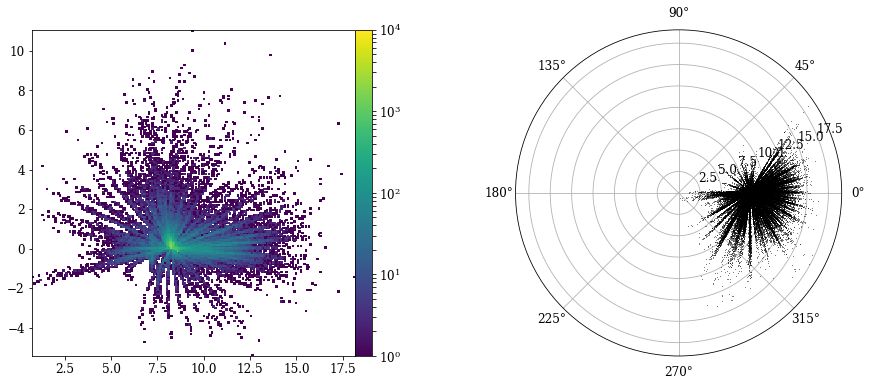

In [10]:
fig = plt.figure(figsize=(15,6))
ax = plt.subplot(121)
histogram2d(fig,ax,cgal.rho.astype('float64'),cgal.z.astype('float64'),bins=200,clabel=False,vmin=1,vmax=1e4,norm='log')
ax = plt.subplot(122,projection='polar')
plt.plot(cgal.phi.astype('float64').to(u.rad)-np.pi*u.rad,cgal.rho.astype('float64'),',',alpha=0.5,color='k')

In [11]:
def bitsNotSet(bitmask,maskbits):
    """
    Given a bitmask, returns True where any of maskbits are set 
    and False otherwise.
    
    bitmask:   bitmask to check
    maskbits:  bits to check if set in the bitmask
    
    """
    goodLocs_bool = np.zeros(bitmask.shape).astype(bool)
    for m in maskbits:
        bitind = bm.bit_set(m,bitmask)
        goodLocs_bool[bitind] = True
    return goodLocs_bool

# Example mask filter function for APOGEE
badcombpixmask = bm.badpixmask()
badcombpixmask += 2**bm.apogee_pixmask_int("SIG_SKYLINE")
badcombpixmask = 7935
maskbits = bm.bits_set(badcombpixmask)

In [12]:
keys = ['C_FE', 'N_FE', 'O_FE', 'MG_FE', 
        'AL_FE', 'SI_FE','S_FE', 'K_FE', 'CA_FE', 
        'TI_FE', 'V_FE', 'CR_FE', 'MN_FE', 'FE_H', 
        'NI_FE']

class clustering(object):
    
    def __init__(self,ra,dec,distance):
        self.ra = ra
        self.dec = dec
        self.distance = distance
        
    def getneighbourhood(self,gaia,radius=100*u.pc,limits=None):
        if radius.cgs.unit==u.cm:
            radius = np.arctan((radius/self.distance).cgs).to(u.degree)
        rabound_min = ((self.ra-(radius))/u.deg).cgs
        rabound_max = ((self.ra+(radius))/u.deg).cgs
        decbound_min = ((self.dec-(radius))/u.deg).cgs
        decbound_max = ((self.dec+(radius))/u.deg).cgs
        cat_ras = gaia['ra']
        cat_decs = gaia['dec']
        ra_errs = gaia['ra_error']
        dec_errs = gaia['dec_error']
            # Find right ascension match
        if rabound_min > 0. and rabound_max < 360.:
            ramatch = (cat_ras>rabound_min) & (cat_ras<rabound_max)
            raplusmatch = (cat_ras+ra_errs>rabound_min) & (cat_ras+ra_errs<rabound_max)
            raminusmatch = (cat_ras-ra_errs>rabound_min) & (cat_ras-ra_errs<rabound_max)
        elif rabound_min < 0. and rabound_max < 360.: 
            ramatch = ((cat_ras>0.) & (cat_ras<rabound_max)) | ((cat_ras>rabound_min+360.) & (cat_ras<360.))
            raplusmatch = ((cat_ras+ra_errs>0.) & (cat_ras+ra_errs<rabound_max)) | ((cat_ras+ra_errs>rabound_min+360.) & (cat_ras+ra_errs<360.))
            raminusmatch = ((cat_ras-ra_errs>0.) & (cat_ras-ra_errs<rabound_max)) | ((cat_ras-ra_errs>rabound_min+360.) & (cat_ras-ra_errs<360.))
        elif rabound_min > 0. and rabound_max > 360.:
            ramatch = ((cat_ras>rabound_min) & (cat_ras<360.)) | ((cat_ras>0.) & (cat_ras<rabound_max-360.))
            raplusmatch = ((cat_ras+ra_errs>rabound_min) & (cat_ras+ra_errs<360.)) | ((cat_ras+ra_errs>0.) & (cat_ras+ra_errs<rabound_max-360.))
            raminusmatch = ((cat_ras-ra_errs>rabound_min) & (cat_ras-ra_errs<360.)) | ((cat_ras-ra_errs>0.) & (cat_ras-ra_errs<rabound_max-360.))
        elif rabound_min < 0. and rabound_max > 360.:
            warnings.warn('Your range spans the whole sky in right ascension, exiting')
            ramatch = False
            raplusmatch = False
            raminusmatch = False

        if decbound_min > 0. and decbound_max < 360.:
            decmatch = (cat_decs>decbound_min) & (cat_decs<decbound_max)
            decplusmatch = (cat_decs+dec_errs>decbound_min) & (cat_decs+dec_errs<decbound_max)
            decminusmatch = (cat_decs-dec_errs>decbound_min) & (cat_decs-dec_errs<decbound_max)
        elif decbound_min < 0. and decbound_max < 360.: 
            decmatch = ((cat_decs>0.) & (cat_decs<decbound_max)) | ((cat_decs>decbound_min+360.) & (cat_decs<360.))
            decplusmatch = ((cat_decs+dec_errs>0.) & (cat_decs+dec_errs<decbound_max)) | ((cat_decs+dec_errs>decbound_min+360.) & (cat_decs+dec_errs<360.))
            decminusmatch = ((cat_decs-dec_errs>0.) & (cat_decs-dec_errs<decbound_max)) | ((cat_decs-dec_errs>decbound_min+360.) & (cat_decs-dec_errs<360.))
        elif decbound_min > 0. and decbound_max > 360.:
            decmatch = ((cat_decs>decbound_min) & (cat_decs<360.)) | ((cat_decs>0.) & (cat_decs<decbound_max-360.))
            decplusmatch = ((cat_decs+dec_errs>decbound_min) & (cat_decs+dec_errs<360.)) | ((cat_decs+dec_errs>0.) & (cat_decs+dec_errs<decbound_max-360.))
            decminusmatch = ((cat_decs-dec_errs>decbound_min) & (cat_decs-dec_errs<360.)) | ((cat_decs-dec_errs>0.) & (cat_decs-dec_errs<decbound_max-360.))
        elif decbound_min < 0. and decbound_max > 360.:
            warnings.warn('Your range spans the whole sky in declination, exiting')
            decmatch = False
            decplusmatch = False
            decminusmatch = False
        self.match = (ramatch & decmatch)
        #self.match_err = ((raplusmatch & decmatch) | (raminusmatch & decmatch) | (ramatch & decplusmatch) | (raplusmatch & decplusmatch) | (raminusmatch & decplusmatch) | (ramatch & decminusmatch) | (raplusmatch & decminusmatch) | (raminusmatch & decminusmatch)) 
        #self.match_err[match] = False
        
    def getneighbours(self,apo,gaia,radius=100*u.pc,limits=None,inclerror=False,gen=True):
        if 'match' not in dir(self) or gen:
            self.getneighbourhood(gaia,radius=radius,limits=limits)
        if not inclerror:
            match=self.match
        elif inclerror:
            match=self.match_err            
        self.gaianeighbour = gaia[match]
        self.apo = apo[match]
        self.num = len(self.gaianeighbour)
        self.spectra = np.zeros((self.num,pixels),dtype=float)
        self.specerrs = np.zeros((self.num,pixels),dtype=float)
        bitmask = np.zeros((self.num,pixels),dtype=int)
        for i in tqdm(range(self.num)):
            try:
                loc = self.apo['LOCATION_ID'][i]
                apid = self.apo['APOGEE_ID'][i]
                spec = apread.aspcapStar(loc,apid.decode('UTF-8'),ext=1,header=False,aspcapWavegrid=True)
                err = apread.aspcapStar(loc,apid.decode('UTF-8'),ext=2,header=False,aspcapWavegrid=True)
                bits = apread.apStar(loc,apid.decode('UTF-8'),ext=3,header=False,aspcapWavegrid=True)[1]
                self.spectra[i] = spec
                self.specerrs[i] = err
                bitmask[i] = bits
            except:
                pass
        specmask = (bitsNotSet(bitmask,maskbits) | (np.array(self.spectra)/np.array(self.specerrs) <= 100))
        self.spectra = np.ma.masked_array(self.spectra,mask=specmask)
        self.specerrs = np.ma.masked_array(self.specerrs,mask=specmask)
        self.data = self.apo
        self.abundances = np.zeros((self.num,len(keys)))
        for key in range(len(keys)):
            self.abundances[:,key] = self.data[keys[key]]
        
        
    def fit_photo(self,pixel,degree=2,minstars = 100,indeps=['TEFF','LOGG']):
        polynomial = PolynomialFeatures(degree=degree)
        unmask = np.invert(self.spectra.mask[:,pixel])
        stars = self.spectra[:,pixel][unmask]
        numstars = len(stars)
        if numstars > minstars:
            indepvars = np.zeros((numstars,len(indeps)))
            for i in range(len(indeps)):
                variable = indeps[i]
                indep = self.data[unmask][variable]
                indepvars[:,i] = indep-np.ma.median(indep)
            indeps = np.matrix(polynomial.fit_transform(indepvars))
            covInverse = np.diag(1./self.specerrs[:,pixel][unmask]**2)
            # find matrix for spectra values
            starsAtPixel = np.matrix(self.spectra[:,pixel][unmask])

            # transform to matrices that have been weighted by the inverse 
            # covariance
            newIndeps = np.dot(indeps.T,np.dot(covInverse,indeps))

            newStarsAtPixel = np.dot(indeps.T,np.dot(covInverse,starsAtPixel.T))
            invNewIndeps = np.linalg.inv(newIndeps)
            # calculate fit coefficients
            coeffs = np.dot(invNewIndeps,newStarsAtPixel)
            #coeffs = np.linalg.lstsq(newIndeps,newStarsAtPixel)[0]
            coeff_errs = np.array([np.sqrt(np.array(invNewIndeps)[i][i]) for i in range(newIndeps.shape[1])])
            bestFit = indeps*coeffs
            return bestFit,coeffs.T,coeff_errs
        elif numstars <= minstars:
            self.spectra.mask[:,pixel] = True
            return None

            
    def fitneighbours(self,apo,gaia,radius=100*u.pc,limits=None,inclerror=False,
                          degree=2,minstars=100,indeps = ['TEFF','LOGG'],gen=True):
        if 'gaianeighbour' not in dir(self) or gen:
            self.getneighbours(apo,gaia,radius=radius,limits=None,inclerror=False,gen=gen)
        self.fitspec = np.ma.masked_array(np.zeros(self.spectra.shape))#,mask=self.spectra.mask)
        polynomial = PolynomialFeatures(degree=degree)
        self.coeffs = np.zeros((pixels,int(sm.comb(degree+len(indeps),len(indeps)))))
        self.coefferrs = np.zeros((pixels,int(sm.comb(degree+len(indeps),len(indeps)))))
        for p in tqdm(range(pixels)):
            unmask = np.invert(self.spectra.mask[:,p])
            try:
                fit,coeff,coefferr = self.fit_photo(p,degree=degree,minstars=minstars,indeps=indeps)
                self.fitspec[:,p][unmask] = np.array(fit).flatten()
                self.coeffs[p]=(np.array(coeff).flatten())
                self.coefferrs[p]=(np.array(coefferr).flatten())
            except TypeError:
                pass
        self.res = self.spectra - self.fitspec
        
        
    def spec_dists(self,apo,gaia,radius=100*u.pc,limits=None,inclerror=False,
                   degree=2,minstars=100,indeps = ['TEFF','LOGG'],gen=True):
        if 'res' not in dir(self) or gen:
            self.fitneighbours(apo,gaia,radius=radius,limits=limits,inclerror=inclerror,
                               degree=degree,minstars=minstars,indeps=indeps,gen=gen)
        self.distances = np.zeros((self.num,self.num))
        self.pix = np.zeros((self.num,self.num))
        for i in tqdm(range(self.num)):
            for j in range(self.num):
                speci = self.res[i]
                specj = self.res[j]
                mask = speci.mask | specj.mask
                unmask = np.logical_not(mask)
                numpix = np.sum(unmask)
                if numpix > 0:
                    norm=np.sqrt(numpix)
                elif numpix == 0:
                    norm=1
                self.distances[i][j] = np.linalg.norm(speci[unmask]-specj[unmask])/norm
                self.pix[i][j] = numpix
        self.distances /= np.max(np.fabs(self.distances))
                
    def dbscan_spec(self,apo,gaia,eps=0.1,min_samples=10,radius=100*u.pc,
                    limits=None,inclerror=False,degree=2,minstars=100,
                    indeps = ['TEFF','LOGG'],gen=True):
        if 'distances' not in dir(self) or gen:
            self.spec_dists(apo,gaia,radius=radius,limits=limits,inclerror=inclerror,
                            degree=degree,minstars=minstars,indeps=indeps,gen=gen)
        db = DBSCAN(eps=eps,min_samples=min_samples,metric='precomputed').fit(self.distances)
        self.spec_labels=db.labels_
        
    def dbscan_keys(self,apo,gaia,eps=0.1,min_samples=10,radius=100*u.pc,
                    limits=None,inclerror=False,gaiakeys=['ra','dec'],apokeys=[],gen=True):
        if 'gaianeighbour' not in dir(self) or gen:
            self.getneighbours(apo,gaia,radius=radius,limits=limits,inclerror=inclerror,gen=gen)
        self.dbarray = np.ma.masked_array(np.zeros((self.num,len(apokeys)+len(gaiakeys))),mask=np.zeros((self.num,len(apokeys)+len(gaiakeys))))
        mask = np.zeros((self.num,len(apokeys)+len(gaiakeys))) 
        for key in range(len(gaiakeys)):
            self.dbarray[:,key] = self.gaianeighbour[gaiakeys[key]]-np.median(self.gaianeighbour[gaiakeys[key]])
            self.dbarray[:,key] /= np.std(np.fabs(self.dbarray[:,key] ))
        for key in range(len(apokeys)):
            bad = np.where((self.apo[apokeys[key]]<-1000) | (self.apo[apokeys[key]]>1000))
            self.dbarray[:,key].mask[bad]=1
            mask[:,key][bad] = 1
            self.dbarray[:,key] = self.apo[apokeys[key]]
            plt.figure(figsize=(15,6))
            plt.plot(self.dbarray[:,key])
            self.dbarray[:,key] -= np.ma.median(self.dbarray[:,key][self.dbarray[:,key]>-1000])
            print(np.std(np.fabs(self.dbarray[:,key][self.dbarray[:,key] > -1000] )))
            self.dbarray[:,key] /= np.std(np.fabs(self.dbarray[:,key][self.dbarray[:,key]>-1000]))
        self.dbarray.mask = mask
        self.keydist = np.zeros((self.num,self.num))
        self.keypix = np.zeros((self.num,self.num))
        for i in tqdm(range(self.num)):
            for j in range(self.num):
                keysi = self.dbarray[i]
                keysj = self.dbarray[j]
                mask = keysi.mask | keysj.mask
                unmask = np.logical_not(mask)
                numpix = np.sum(unmask)
                if numpix > 0:
                    norm=np.sqrt(numpix)
                elif numpix == 0:
                    norm=1
                self.keydist[i][j] = np.linalg.norm(keysi[unmask]-keysj[unmask])/norm
                self.keypix[i][j] = numpix
        
        db = DBSCAN(eps=eps,min_samples=min_samples,metric='precomputed').fit(self.keydist)
        self.keys_labels=db.labels_
        
    def plot_labels(self,lab=None):
        plt.figure(figsize=(20,6))
        plt.subplot(141)
        plt.plot(self.gaianeighbour['ra'][lab<0],m67.gaianeighbour['dec'][lab<0],'.',color='k',markersize=3,alpha=0.25,zorder=1)
        plt.scatter(self.gaianeighbour['ra'][lab>=0],self.gaianeighbour['dec'][lab>=0],c=lab[lab>=0],marker='.',cmap='cool',zorder=2)
        plt.xlabel('Right ascension')
        plt.ylabel('Declination')
        plt.subplot(142)
        absmag = self.gaianeighbour['phot_g_mean_mag']-5*np.log10(100./self.gaianeighbour['parallax'])
        plt.plot(self.gaianeighbour['bp_rp'][lab<0],absmag[lab<0],'.',color='k',markersize=3,alpha=0.25,zorder=1)
        plt.scatter(self.gaianeighbour['bp_rp'][lab>=0],absmag[lab>=0],c=lab[lab>=0],marker='.',cmap='cool',zorder=2)
        #plt.xlim(3,0)
        plt.ylim(10,-2)
        plt.xlabel('BP-RP')
        plt.ylabel('G mag')
        plt.subplot(143)
        plt.plot(self.apo['TEFF'][lab<0],m67.apo['LOGG'][lab<0],'.',color='k',markersize=3,alpha=0.25,zorder=1)
        plt.scatter(self.apo['TEFF'][lab>=0],self.apo['LOGG'][lab>=0],c=lab[lab>=0],marker='.',cmap='cool',zorder=2)
        plt.xlim(6000,3500)
        plt.ylim(4,0)
        plt.xlabel('Effective temperature')
        plt.ylabel('Surface gravity')
        plt.subplot(144)
        plt.plot(1./(self.gaianeighbour['parallax'][lab<0]),lab[lab<0],'.',color='k',markersize=3,alpha=0.25,zorder=1)
        plt.scatter(1./(self.gaianeighbour['parallax'][lab>=0]),lab[lab>=0],c=lab[lab>=0],marker='.',cmap='cool',zorder=2)
        plt.xlabel('distance (kpc)')
        plt.ylabel('cluster label')
        plt.tight_layout()

In [13]:
c = SkyCoord('08h51m18.0s','+11d48m00s',frame='icrs') # from Xin & Deng 2005
m67_loc = np.array([(c.ra.deg,c.dec.deg)], dtype=[('ra','float'),('dec','float')])
m67_dist = 986.279*u.pc # in pc from Pandey, Sandhu, Sagar & Battinelli 2010
m67 = clustering(c.ra.deg*u.deg,c.dec.deg*u.deg,m67_dist)

eps = 0.005, min_samples=2
eps = 0.005, min_samples=3
eps = 0.005, min_samples=4
eps = 0.005, min_samples=5
eps = 0.005, min_samples=6
eps = 0.005, min_samples=7
eps = 0.005, min_samples=8
eps = 0.005, min_samples=9
eps = 0.005, min_samples=10
eps = 0.005, min_samples=15
eps = 0.005, min_samples=20
eps = 0.005, min_samples=50
eps = 0.01, min_samples=2
eps = 0.01, min_samples=3
eps = 0.01, min_samples=4
eps = 0.01, min_samples=5
eps = 0.01, min_samples=6
eps = 0.01, min_samples=7
eps = 0.01, min_samples=8
eps = 0.01, min_samples=9
eps = 0.01, min_samples=10


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

eps = 0.01, min_samples=15
eps = 0.01, min_samples=20
eps = 0.01, min_samples=50
eps = 0.02, min_samples=2


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

eps = 0.02, min_samples=3
eps = 0.02, min_samples=4
eps = 0.02, min_samples=5


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

eps = 0.02, min_samples=6
eps = 0.02, min_samples=7


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

eps = 0.02, min_samples=8
eps = 0.02, min_samples=9
eps = 0.02, min_samples=10
eps = 0.02, min_samples=15


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

eps = 0.02, min_samples=20
eps = 0.02, min_samples=50


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


eps = 0.05, min_samples=2
eps = 0.05, min_samples=3
eps = 0.05, min_samples=4


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


eps = 0.05, min_samples=5
eps = 0.05, min_samples=6


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

eps = 0.05, min_samples=7
eps = 0.05, min_samples=8


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

eps = 0.05, min_samples=9
eps = 0.05, min_samples=10
eps = 0.05, min_samples=15
eps = 0.05, min_samples=20


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


eps = 0.05, min_samples=50
eps = 0.075, min_samples=2


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

eps = 0.075, min_samples=3
eps = 0.075, min_samples=4


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


eps = 0.075, min_samples=5
eps = 0.075, min_samples=6
eps = 0.075, min_samples=7


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


eps = 0.075, min_samples=8
eps = 0.075, min_samples=9


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


eps = 0.075, min_samples=10
eps = 0.075, min_samples=15


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


eps = 0.075, min_samples=20
eps = 0.075, min_samples=50


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


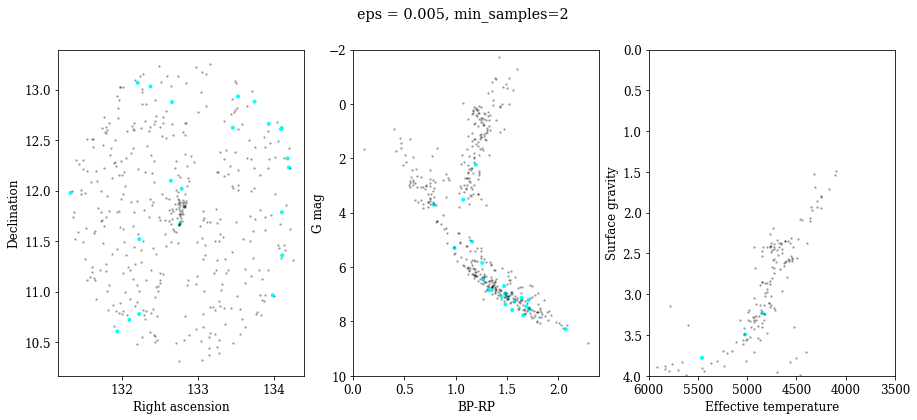

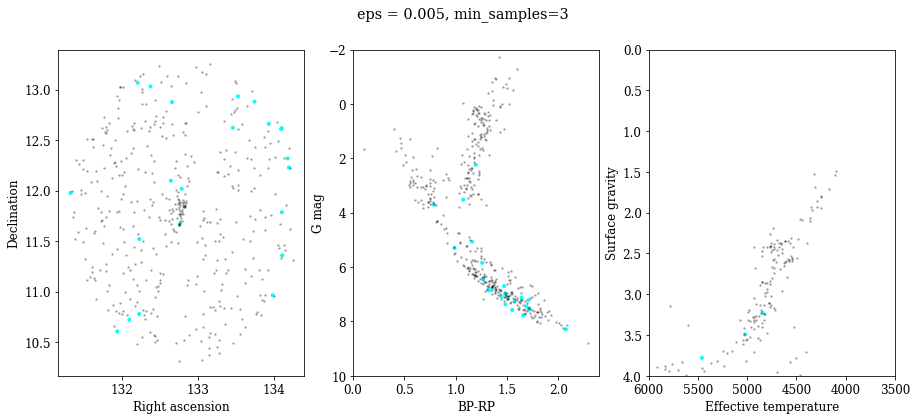

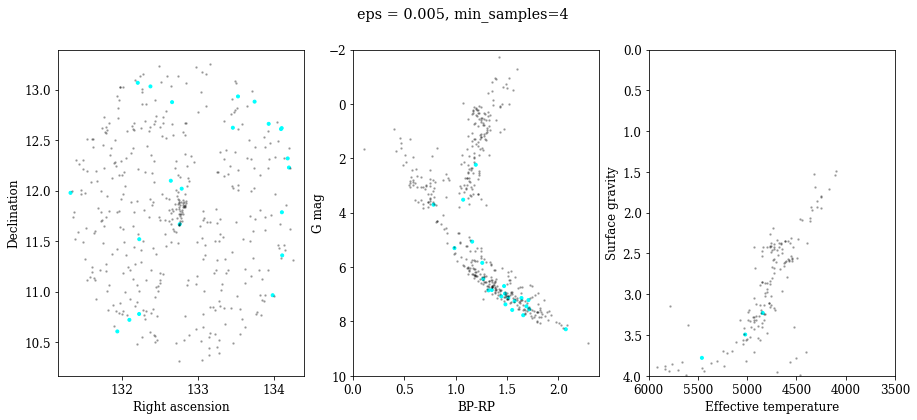

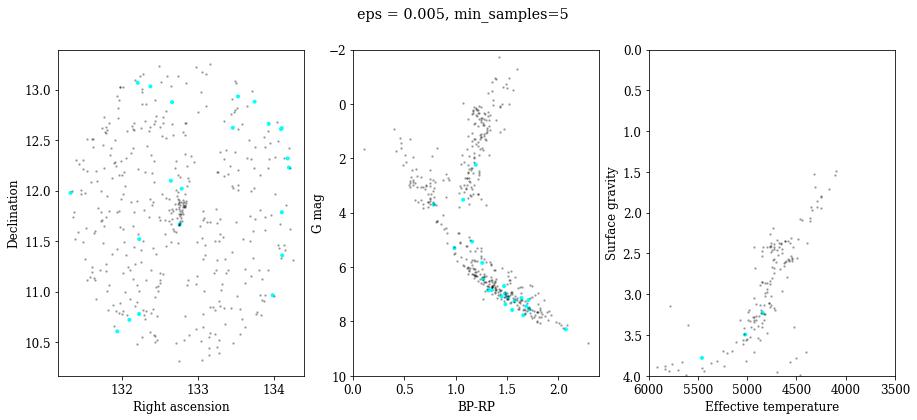

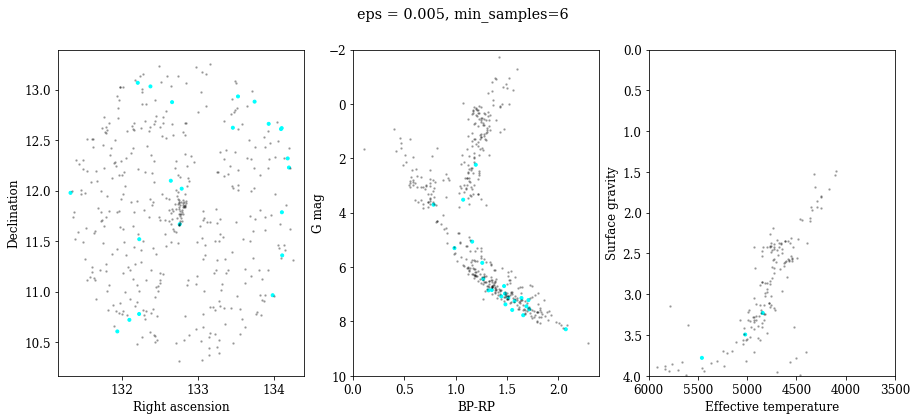

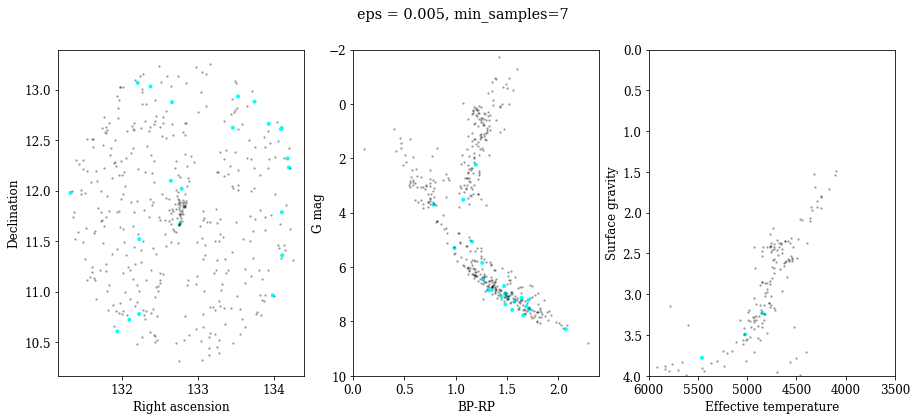

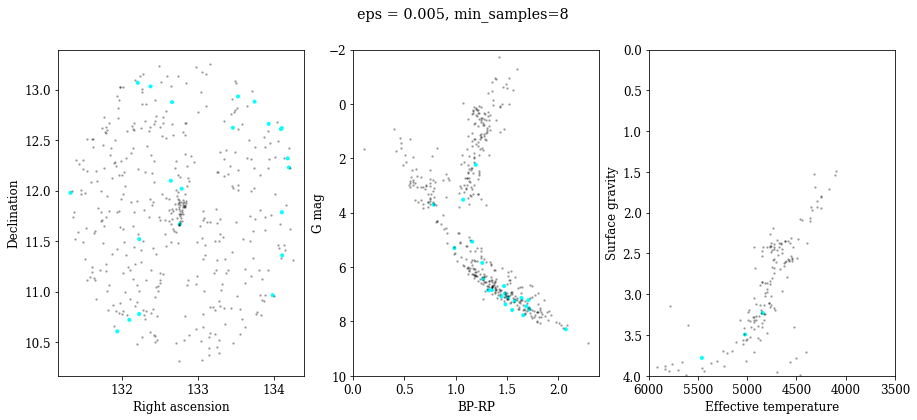

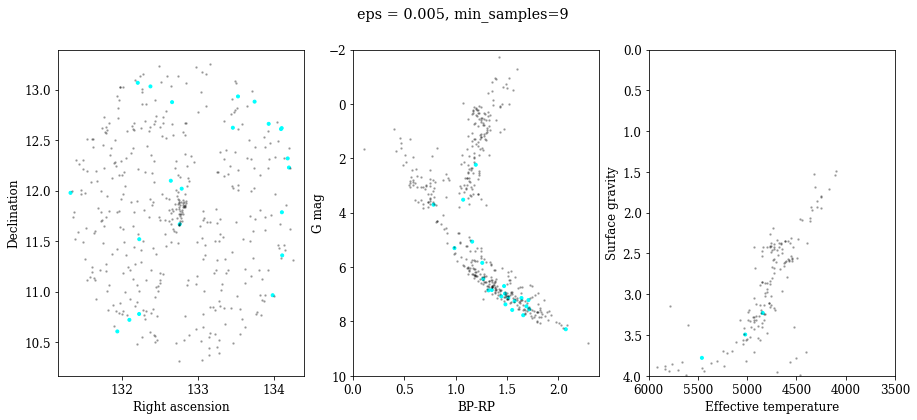

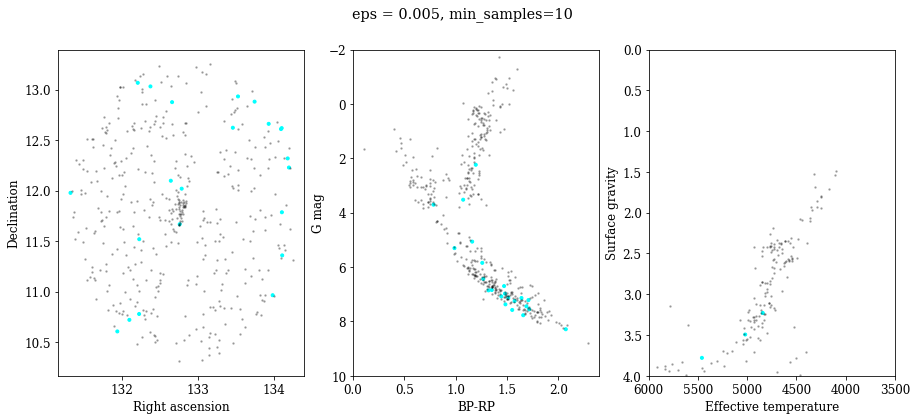

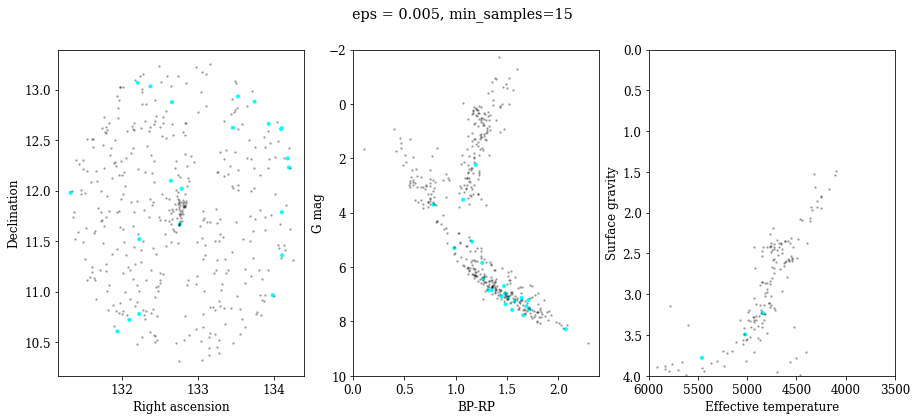

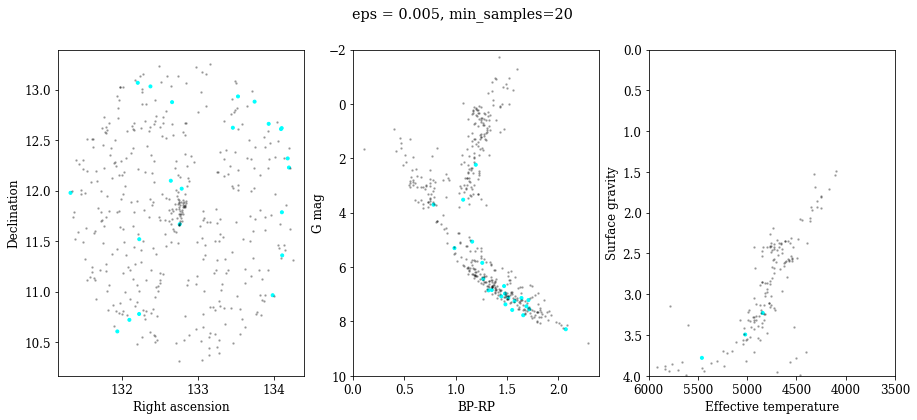

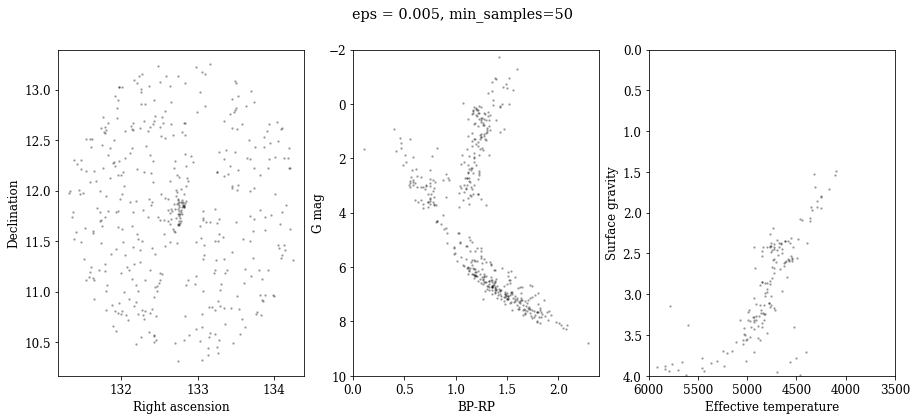

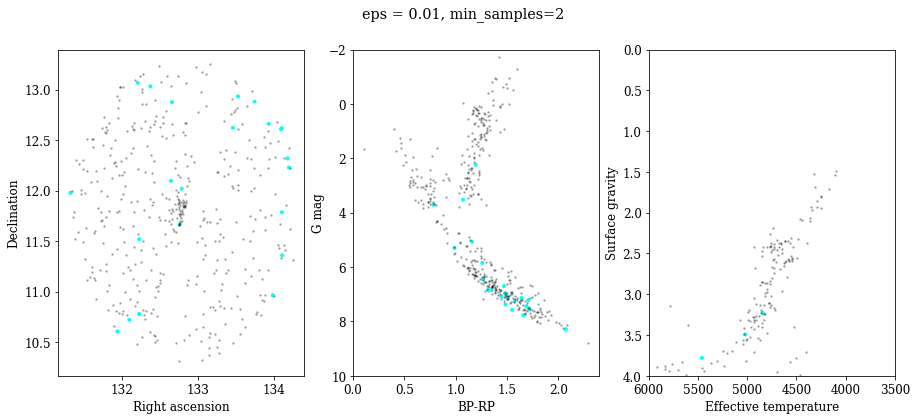

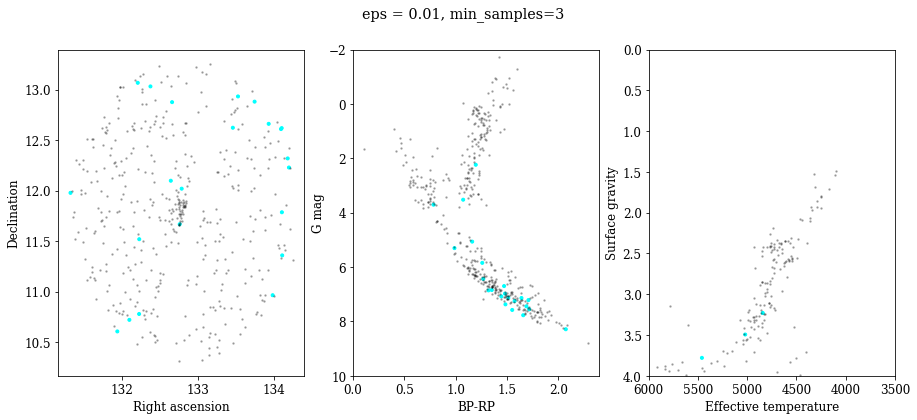

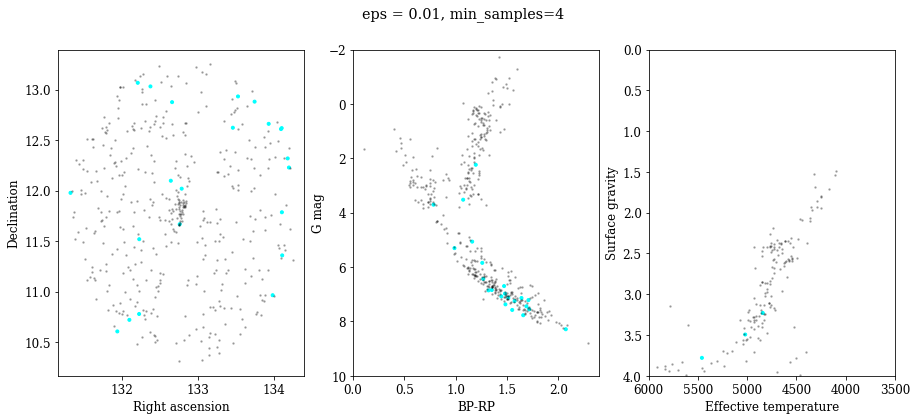

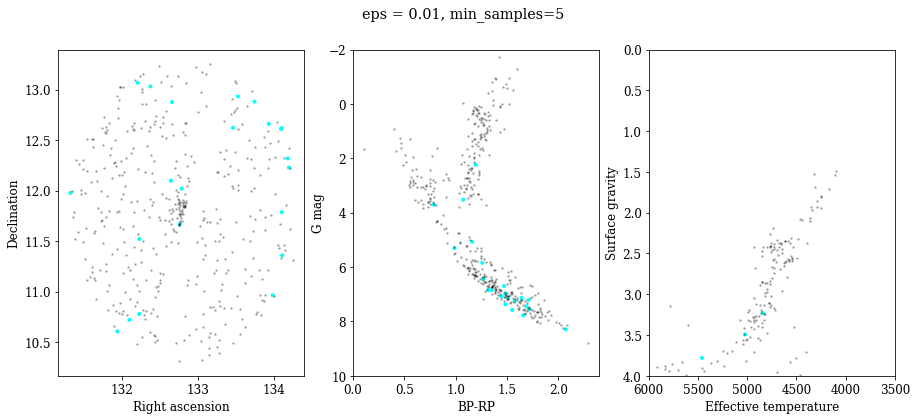

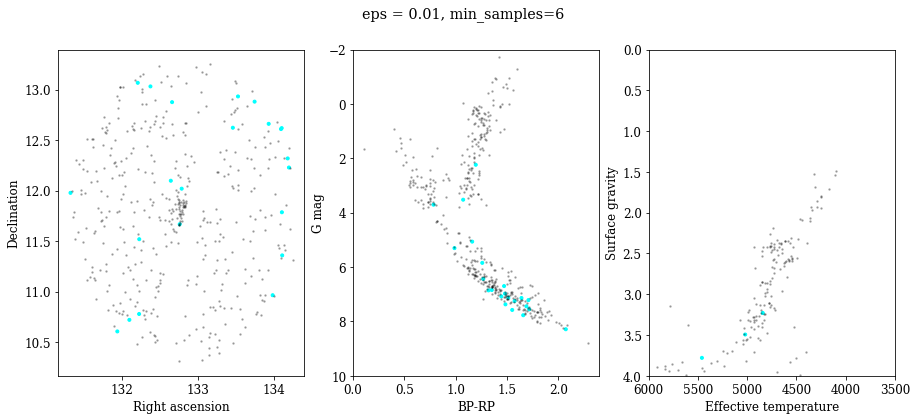

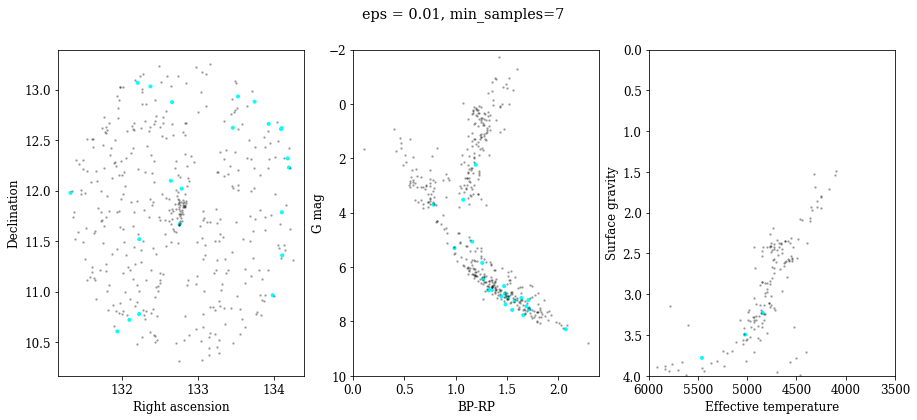

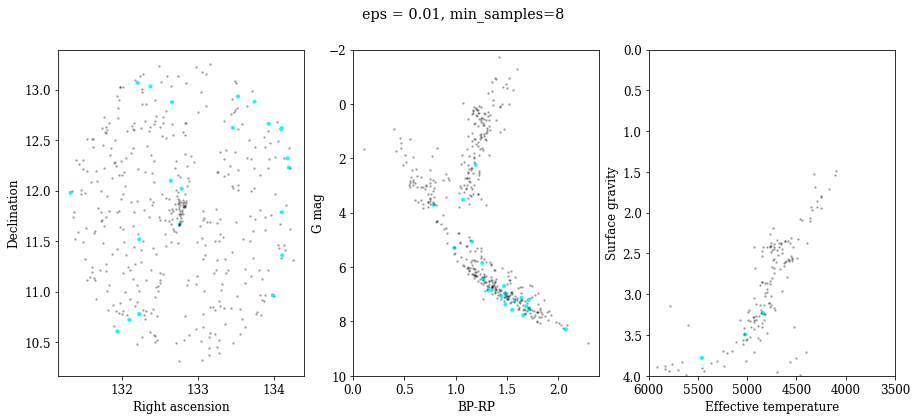

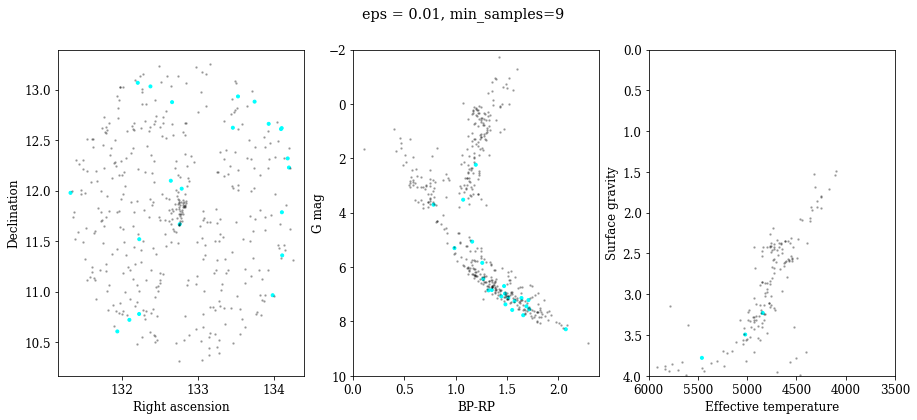

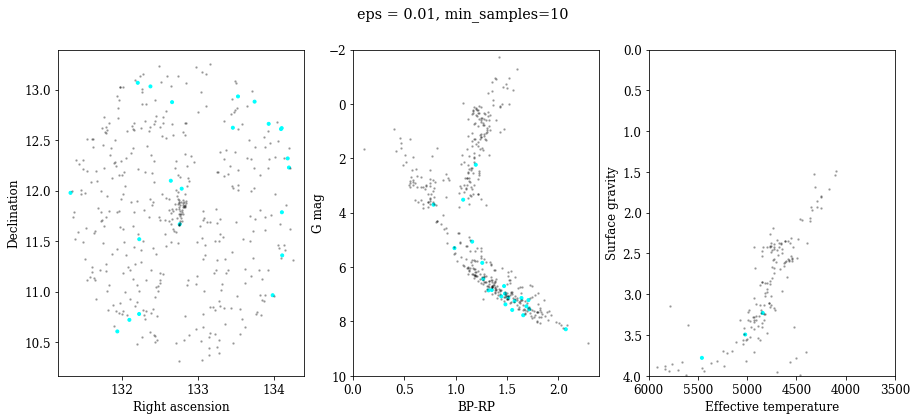

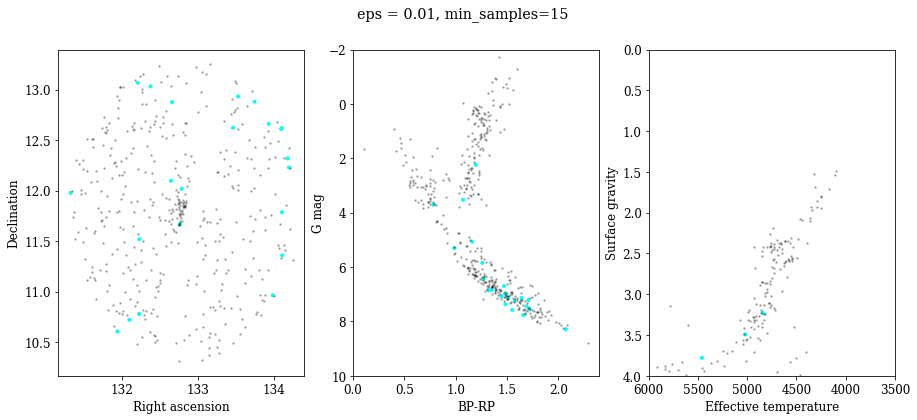

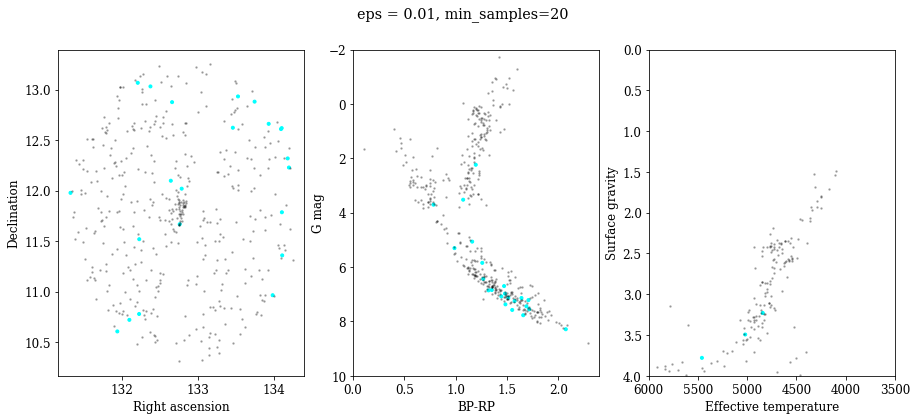

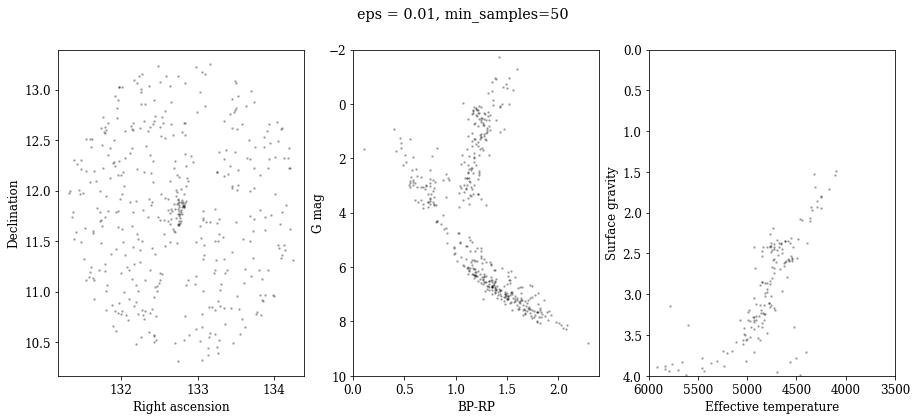

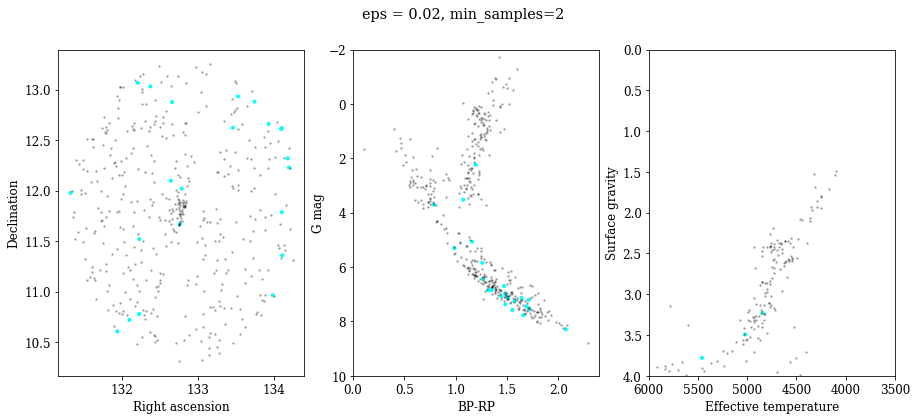

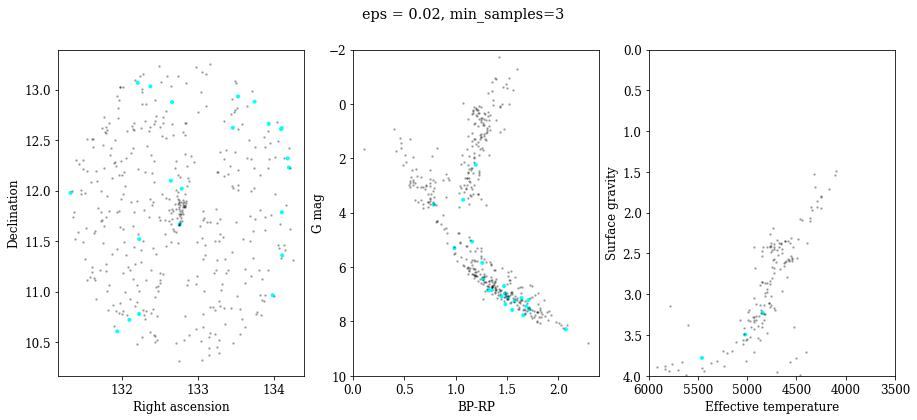

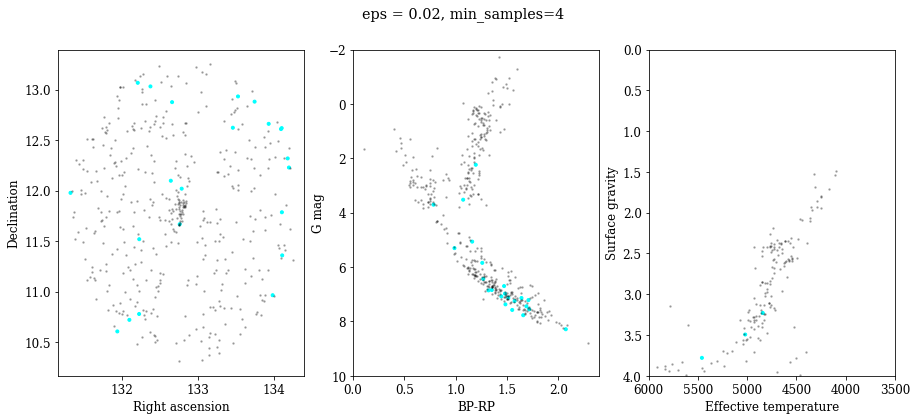

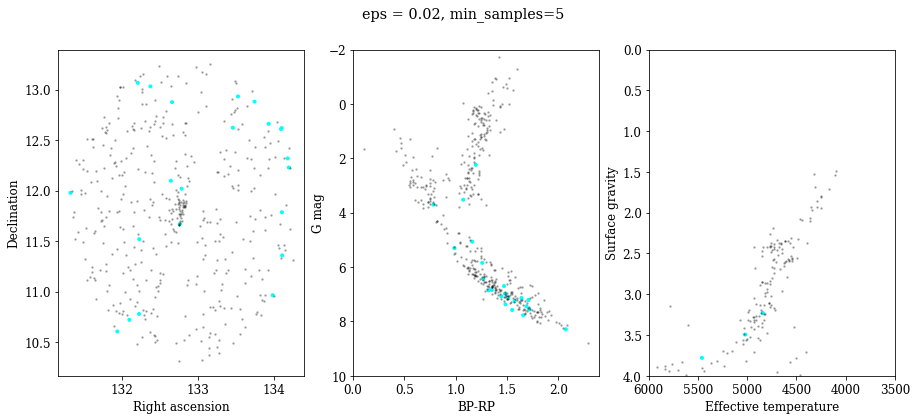

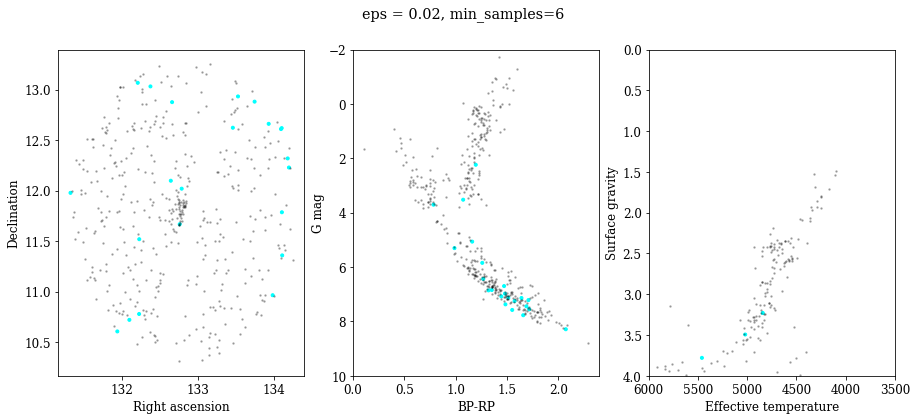

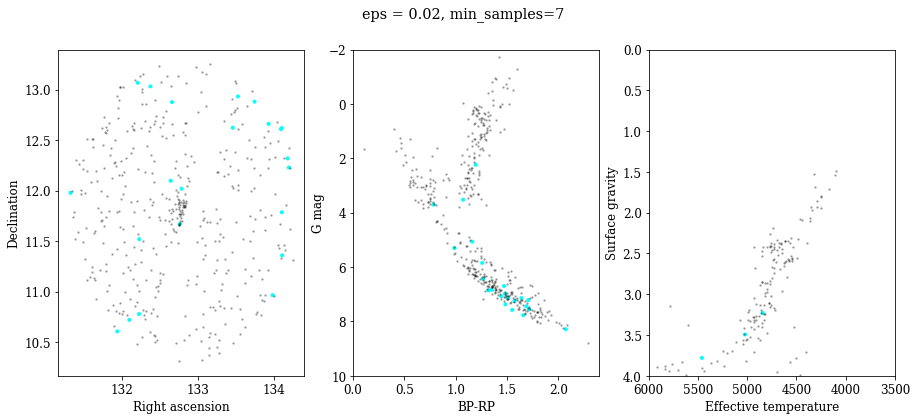

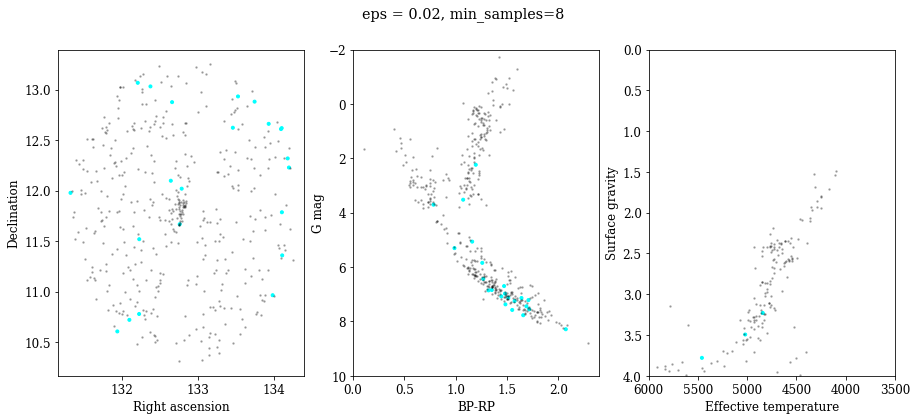

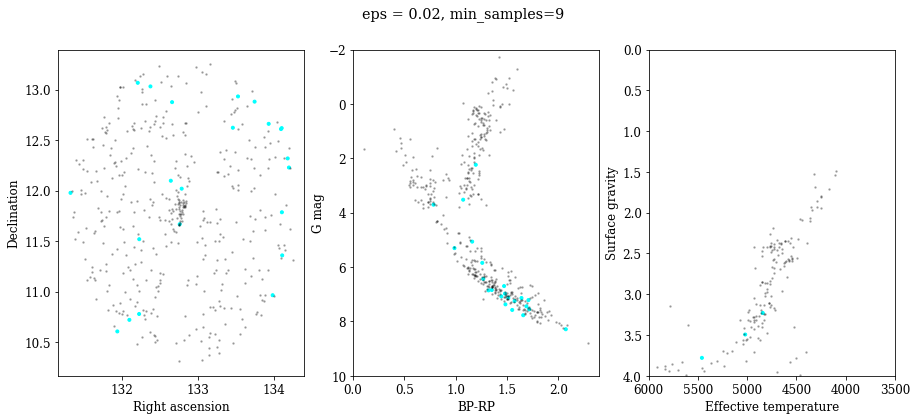

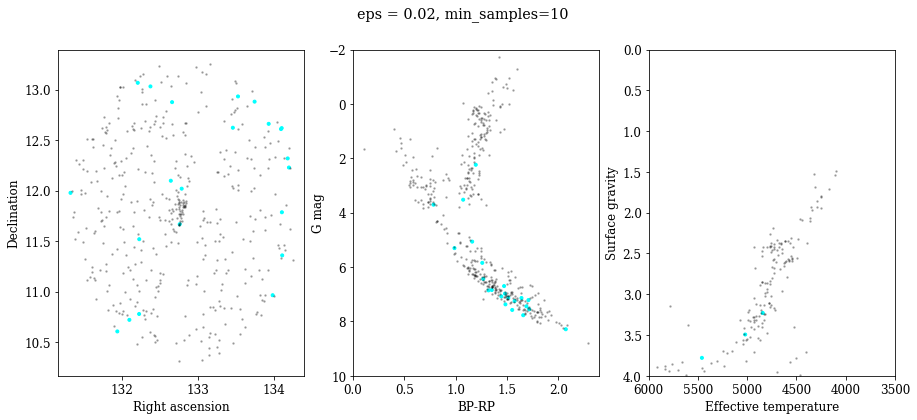

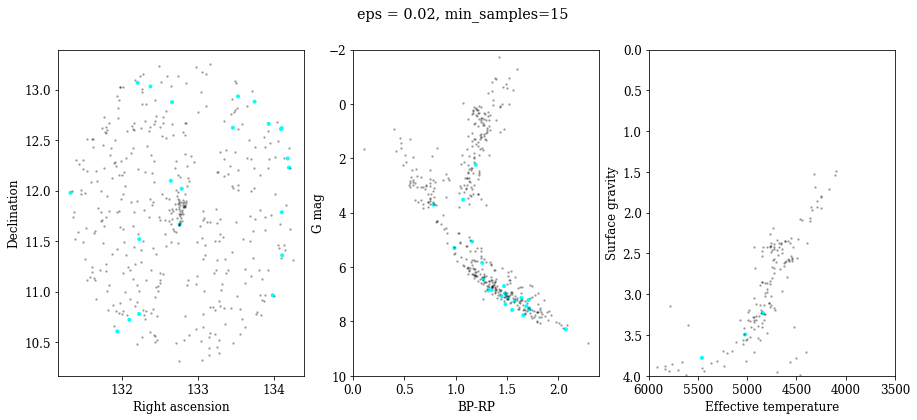

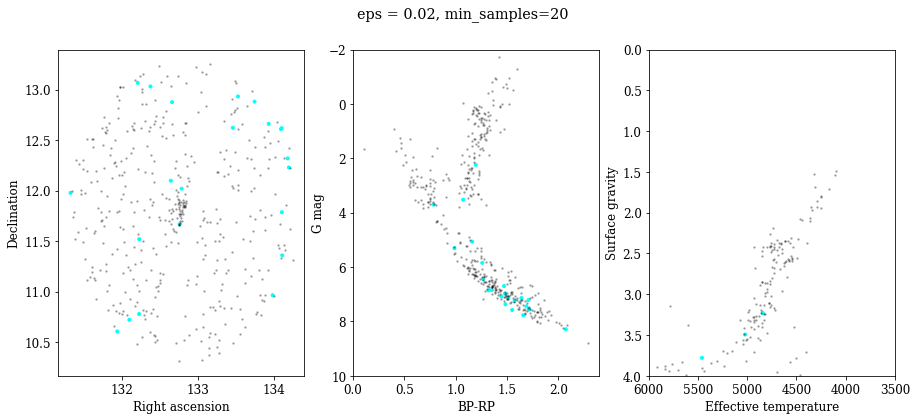

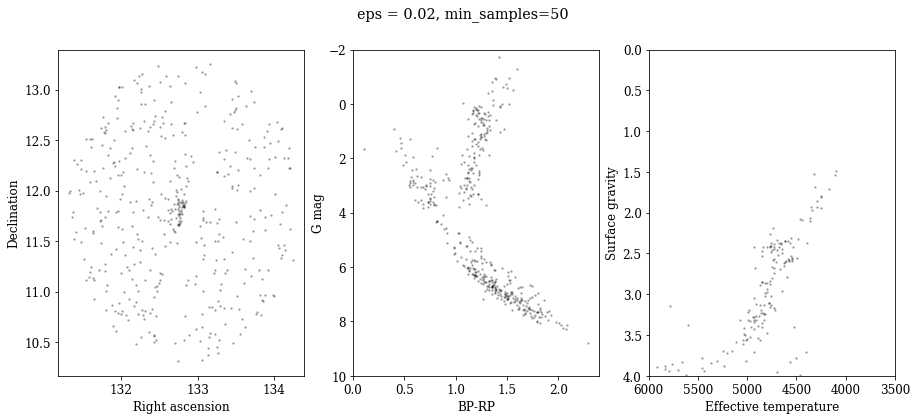

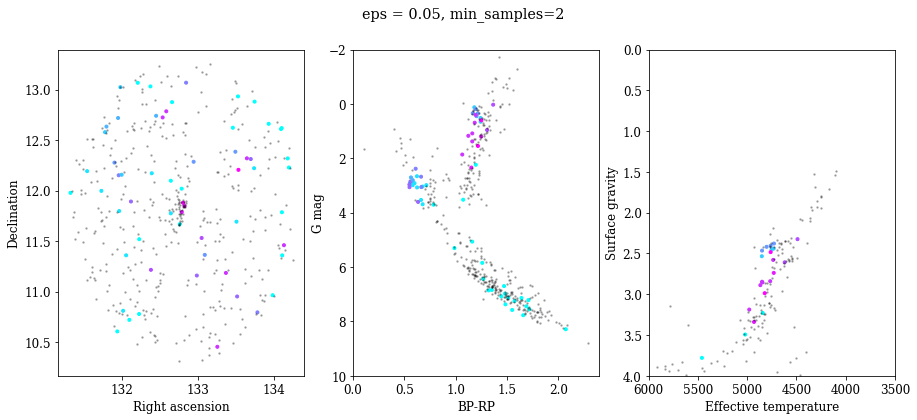

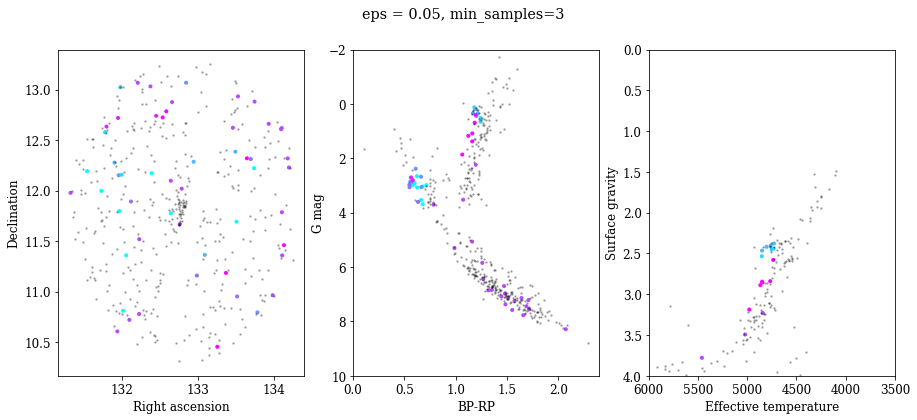

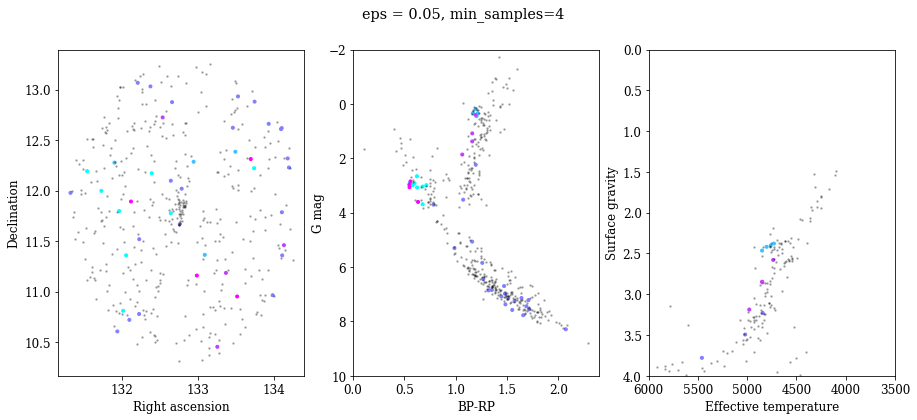

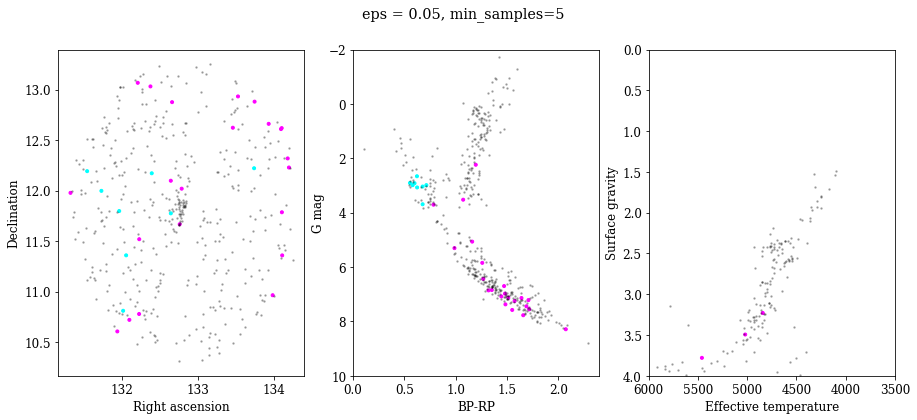

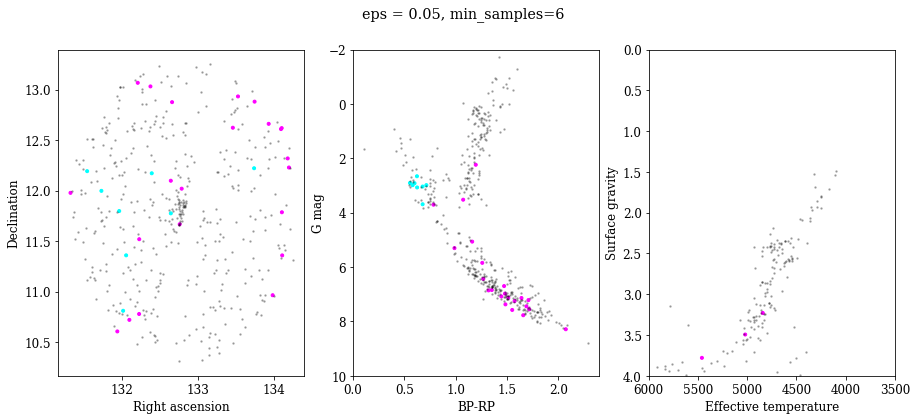

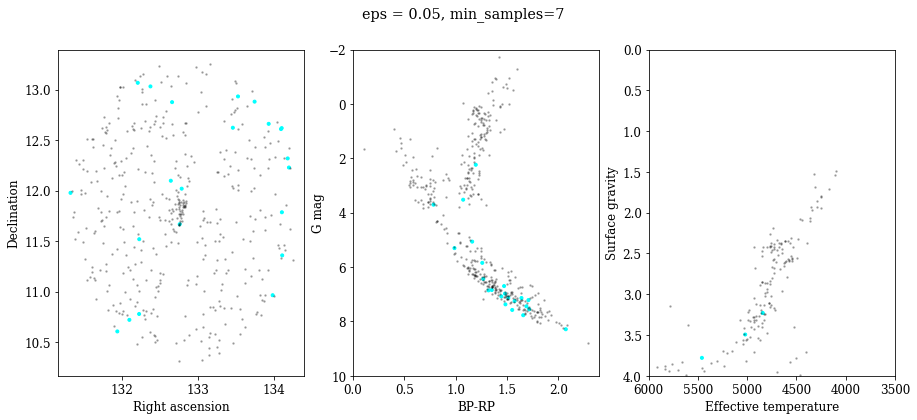

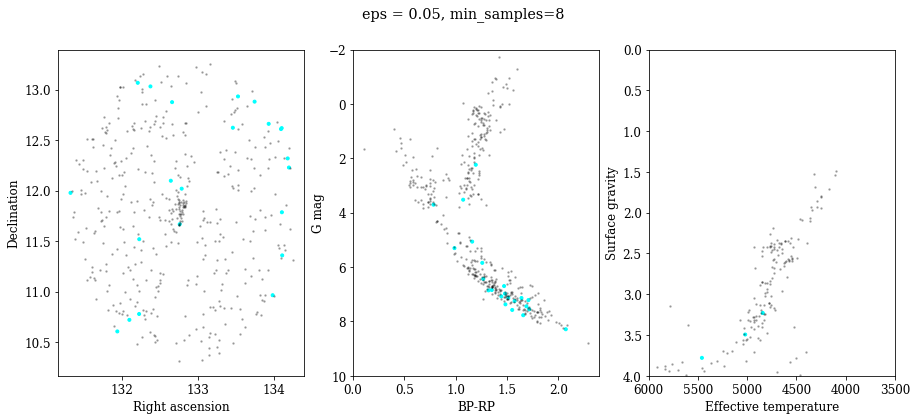

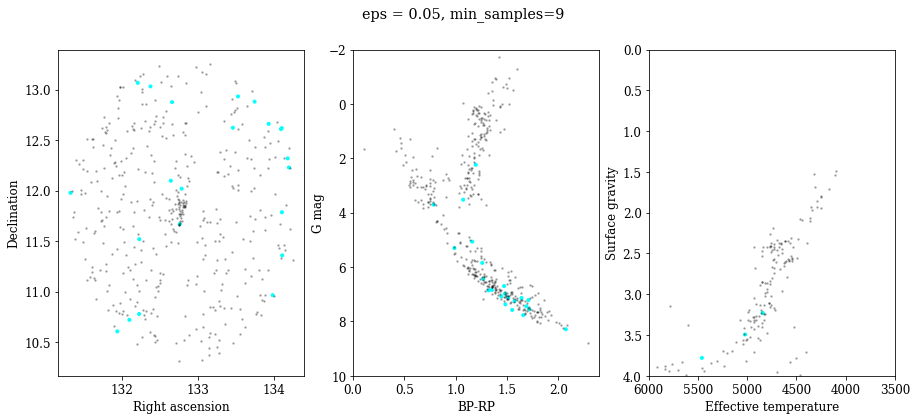

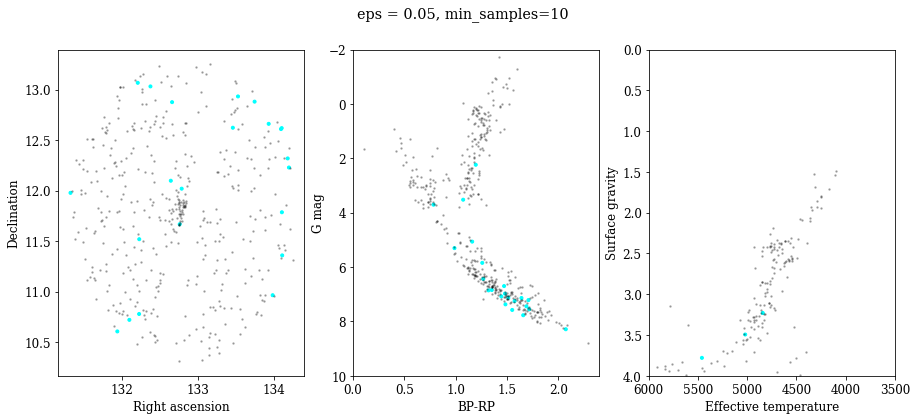

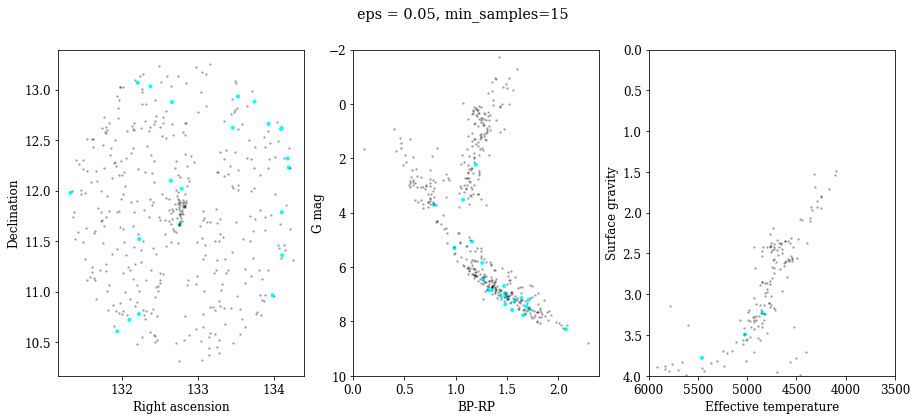

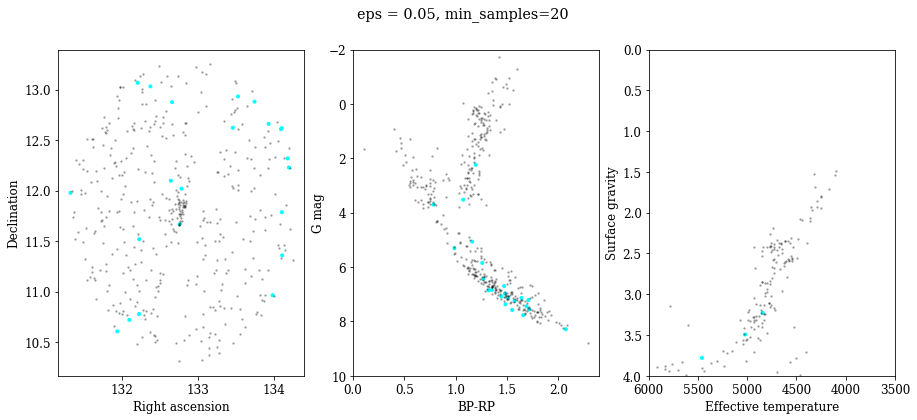

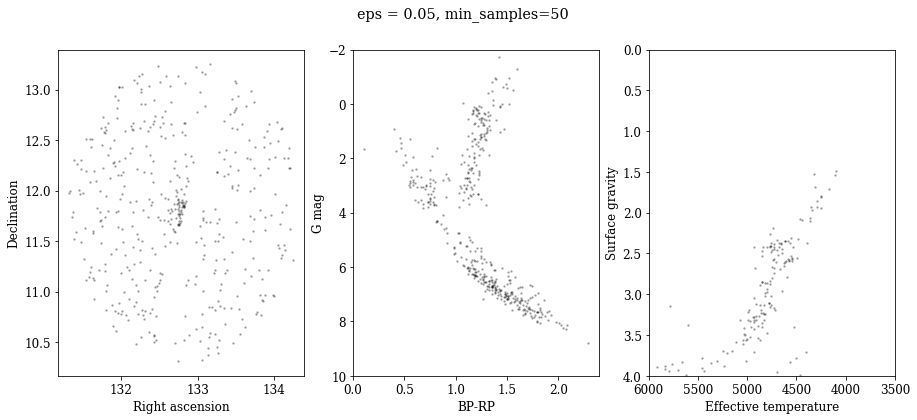

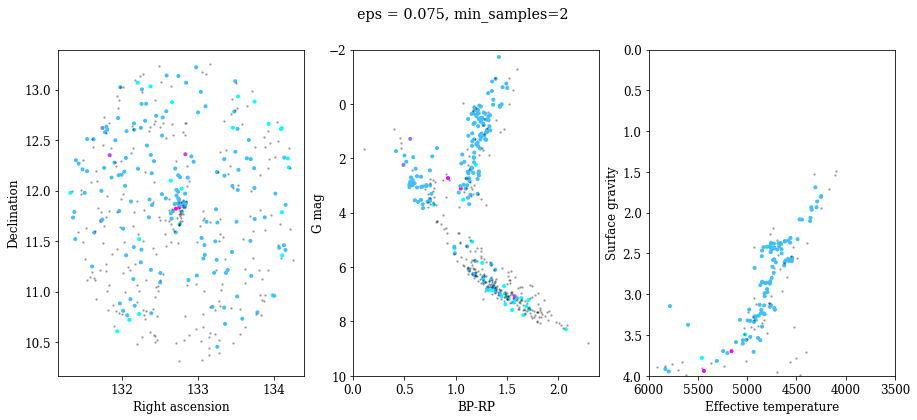

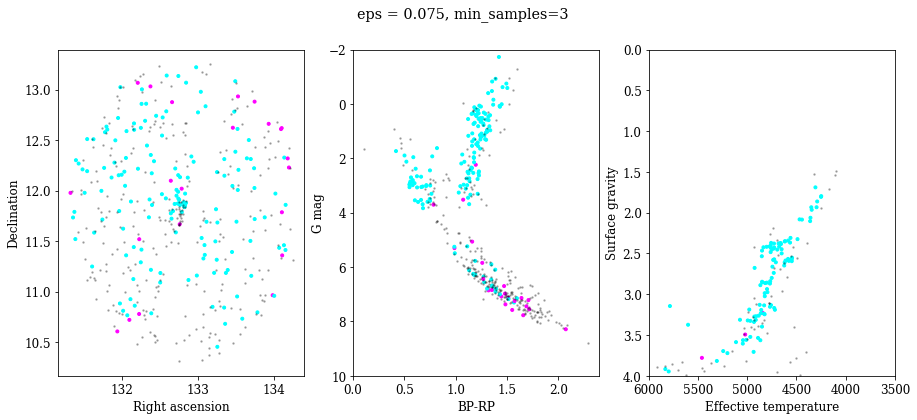

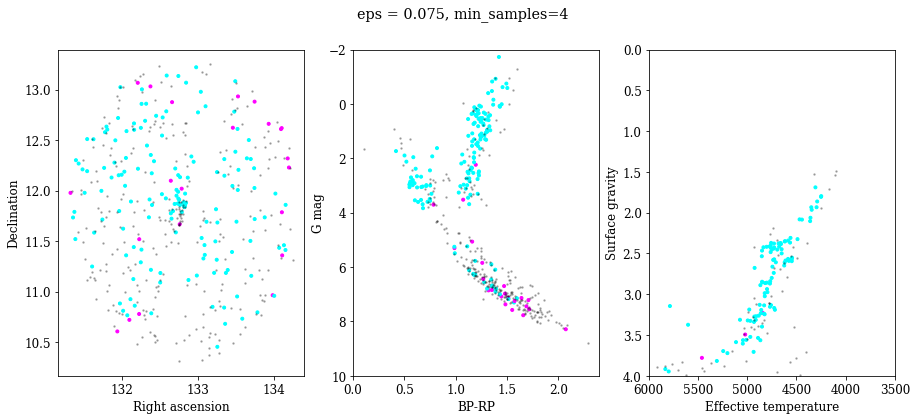

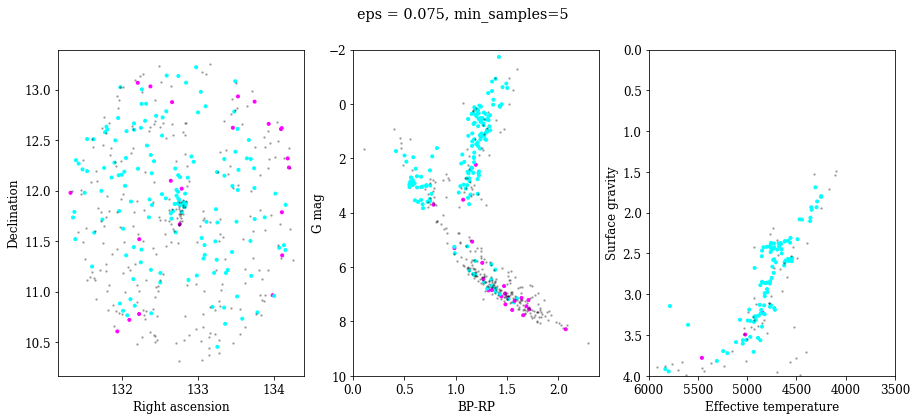

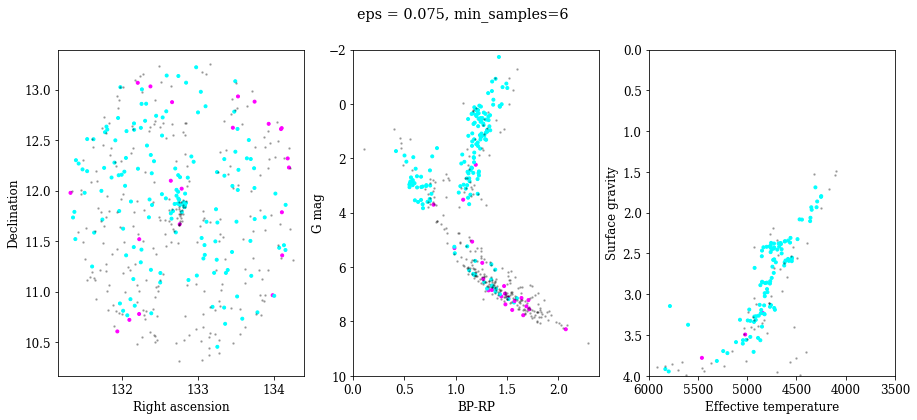

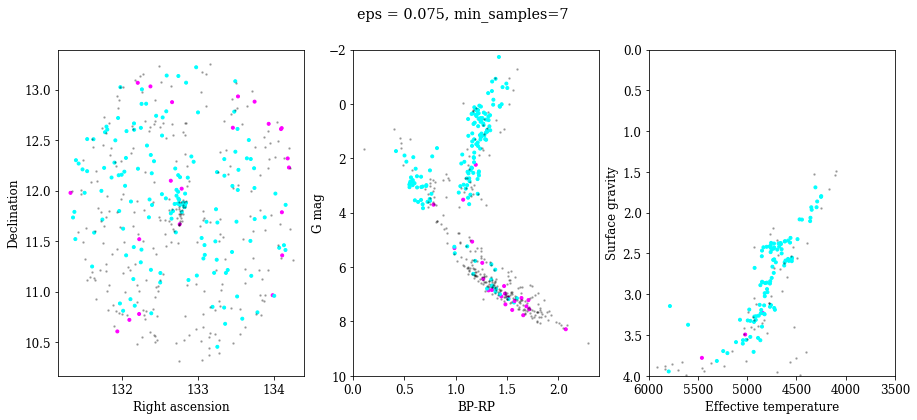

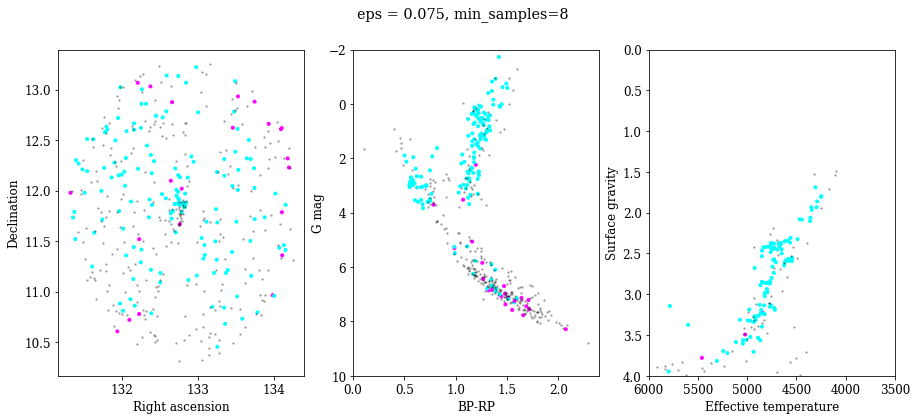

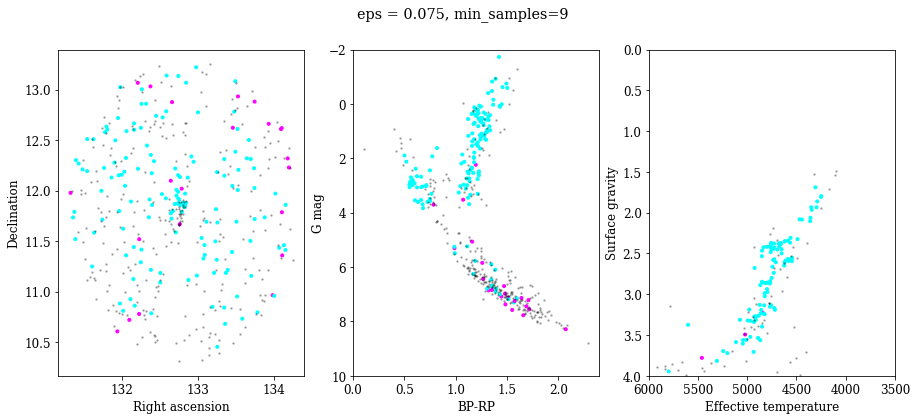

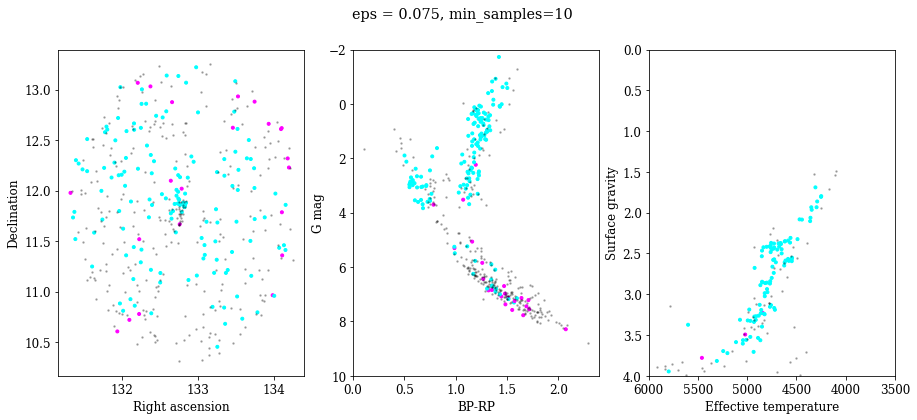

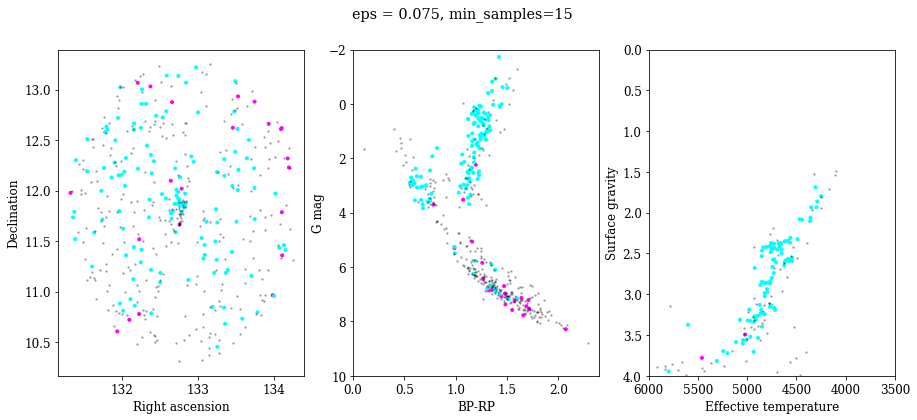

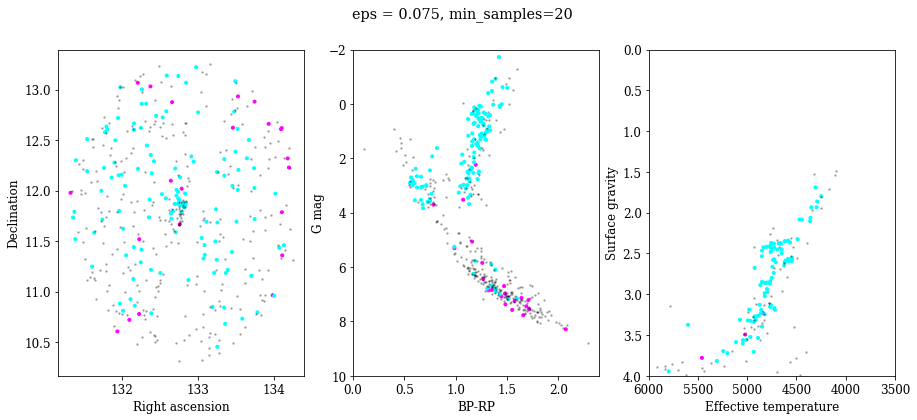

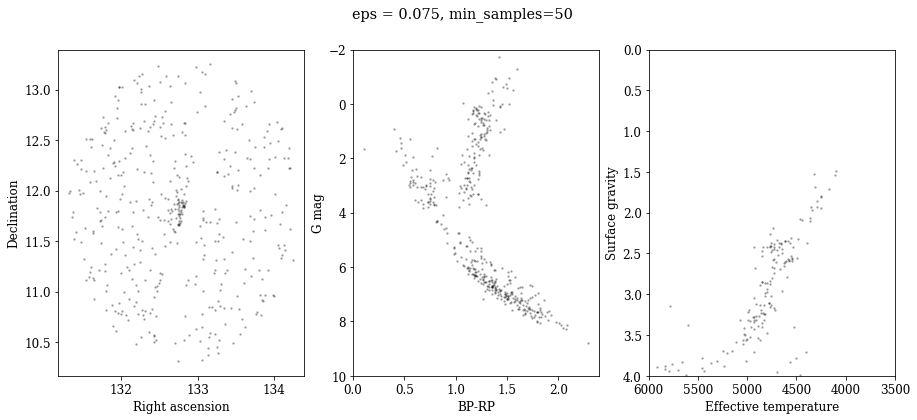

In [83]:
min_samples = np.array([2,3,4,5,6,7,8,9,10,15,20,50])
samples = len(min_samples)
eps = np.array([0.005,0.01,0.02,0.05,0.075])#,0.1,0.5,1.0])
min_samples = np.tile(min_samples,len(eps))
eps = np.repeat(eps,samples)
for i in range(len(eps)):
    print('eps = {0}, min_samples={1}'.format(eps[i],min_samples[i]))
    m67.dbscan_spec(apo,g2,radius=2*u.deg,eps=eps[i],min_samples=min_samples[i],gen=False)
    m67.plot_labels(lab=m67.spec_labels)
    plt.suptitle('eps = {0}, min_samples={1}'.format(eps[i],min_samples[i]))

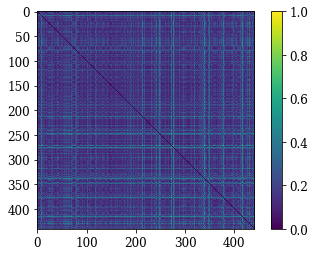

In [80]:
plt.imshow(m67.distances,aspect=m67.distances.shape[1]/float(m67.distances.shape[0]))
plt.colorbar()

100%|██████████| 441/441 [00:37<00:00, 12.16it/s]


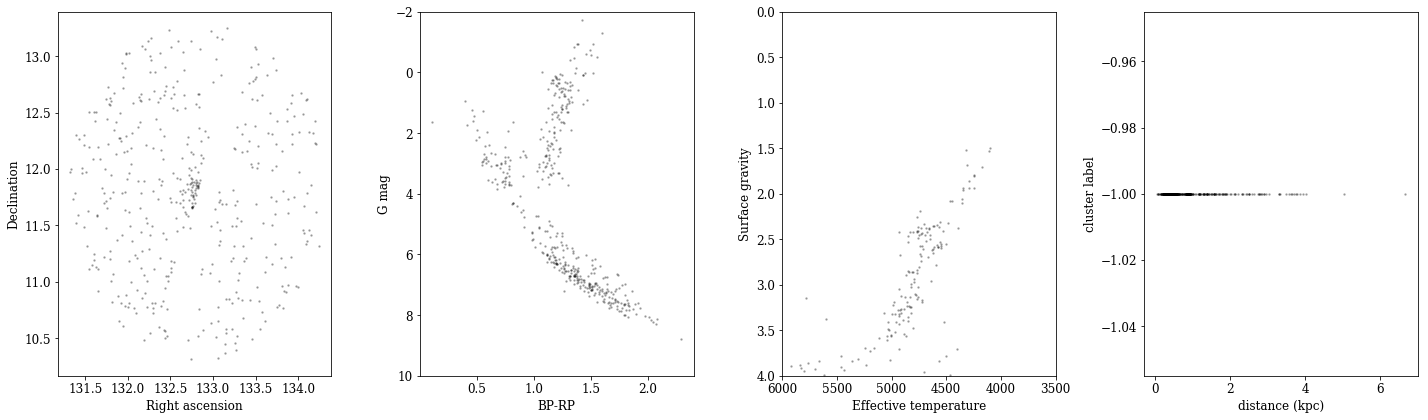

In [21]:
m67.dbscan_keys(apo,g2,radius=2*u.deg,eps=0.05,min_samples=25,gaiakeys=['ra','dec','parallax','pmra','pmdec'],gen=False)
m67.plot_labels(lab=m67.keys_labels)

100%|██████████| 441/441 [00:35<00:00, 12.43it/s]


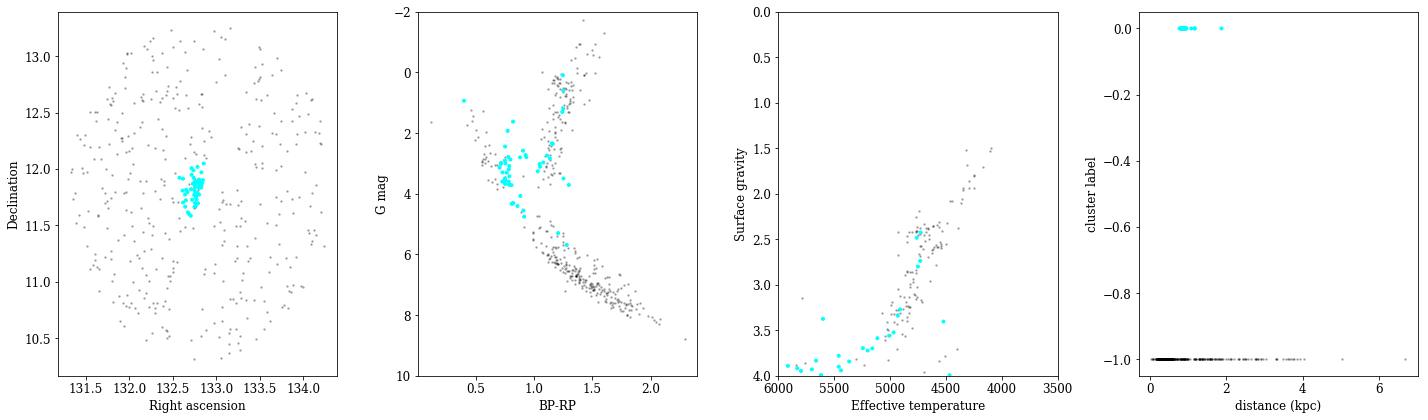

In [14]:
m67.dbscan_keys(apo,g2,radius=2*u.deg,eps=0.2,min_samples=25,gaiakeys=['ra','dec','parallax','pmra','pmdec'],gen=False)
m67.plot_labels(lab=m67.keys_labels)

0.0506788139889
0.0961438133519
0.0829794756923
0.0743313428382
0.0912229001869
0.0543664270237
0.0831969104085
0.0548979803272
0.0979323247909
0.230689196156
0.116548364781
0.0432003384937
0.158553549403


  0%|          | 2/441 [00:00<00:33, 13.24it/s]

0.029694732301


100%|██████████| 441/441 [00:36<00:00, 12.00it/s]


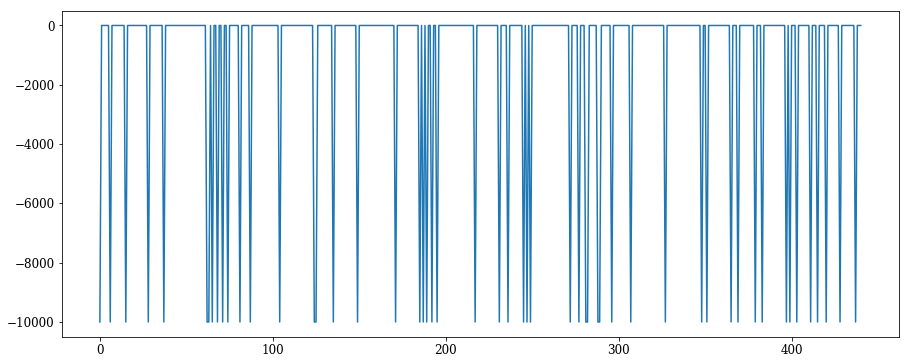

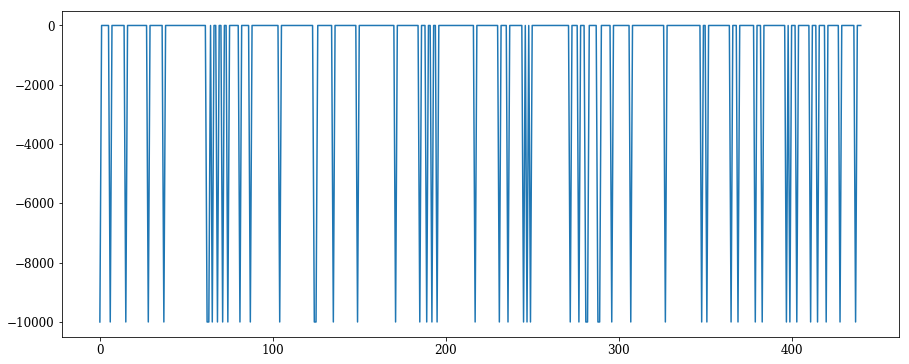

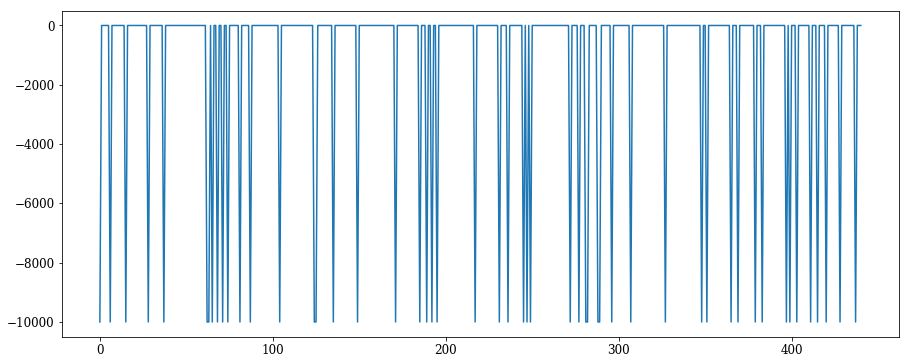

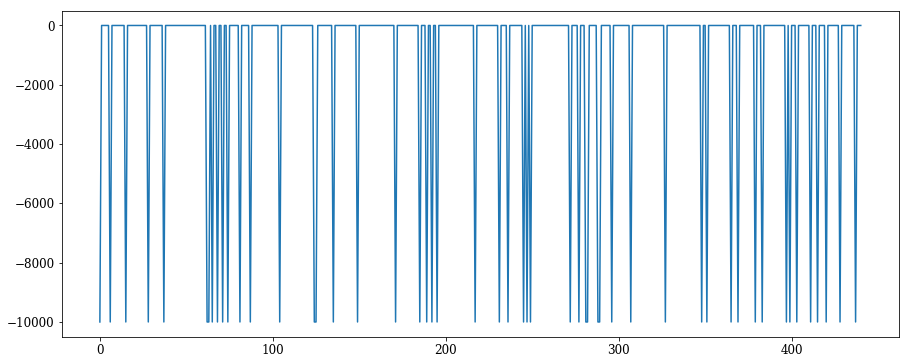

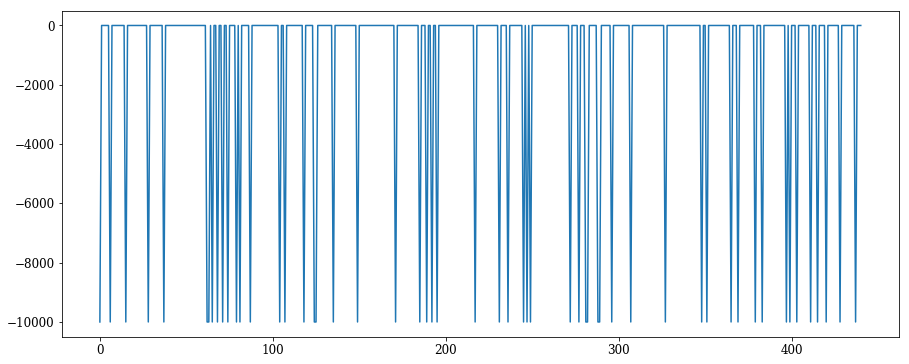

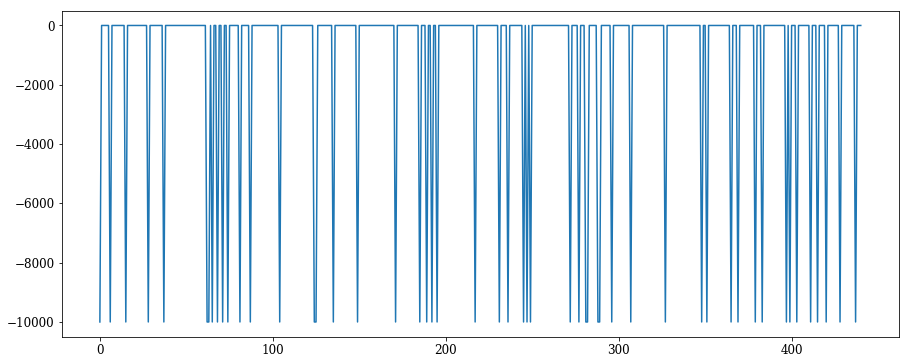

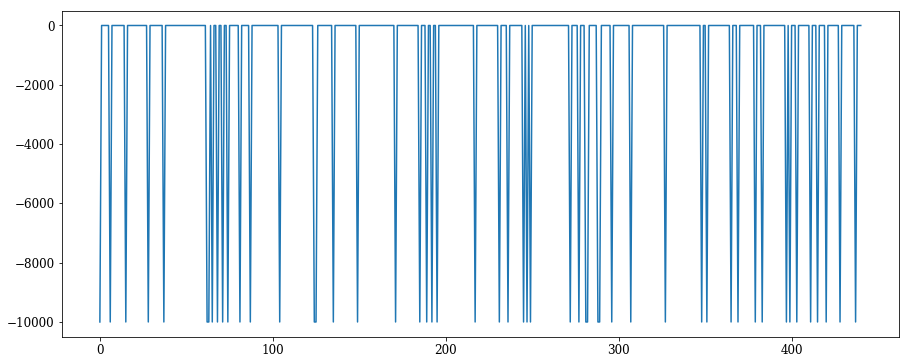

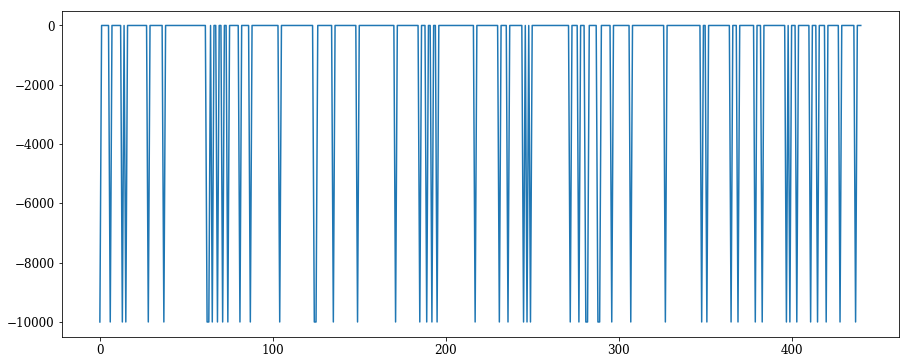

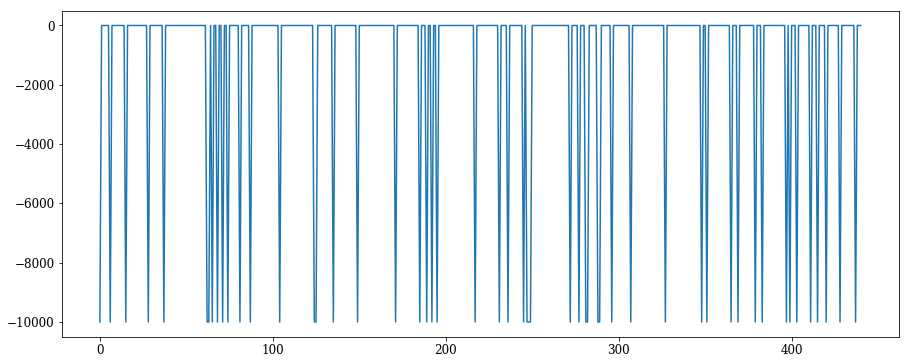

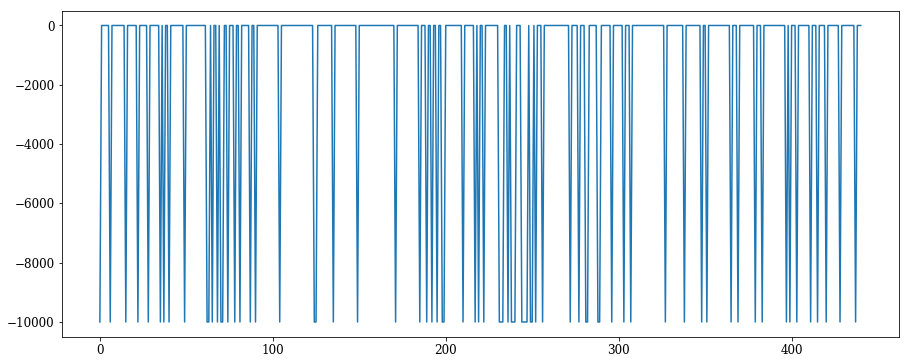

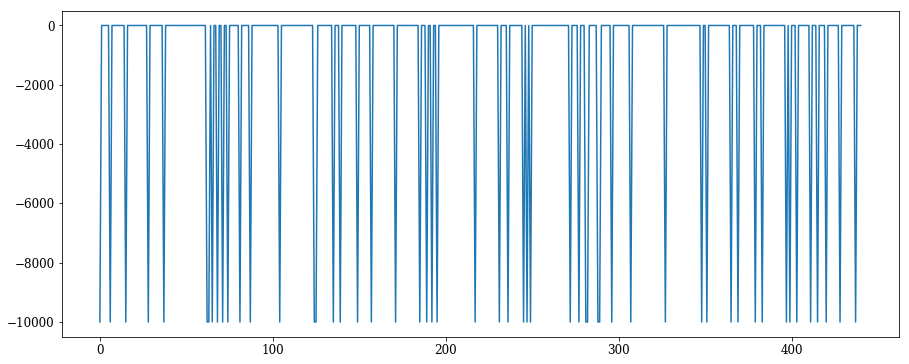

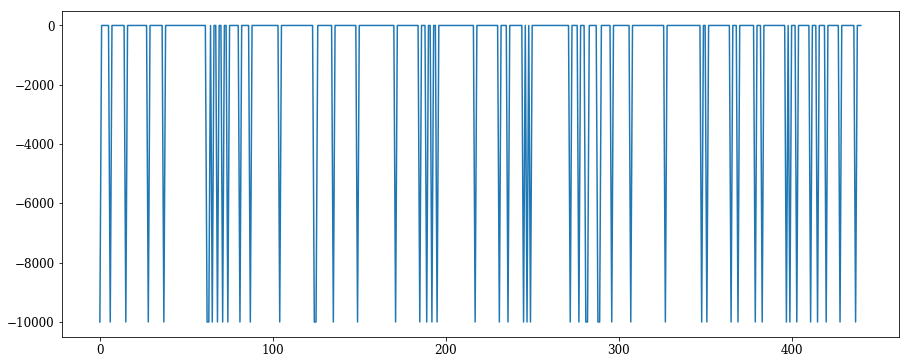

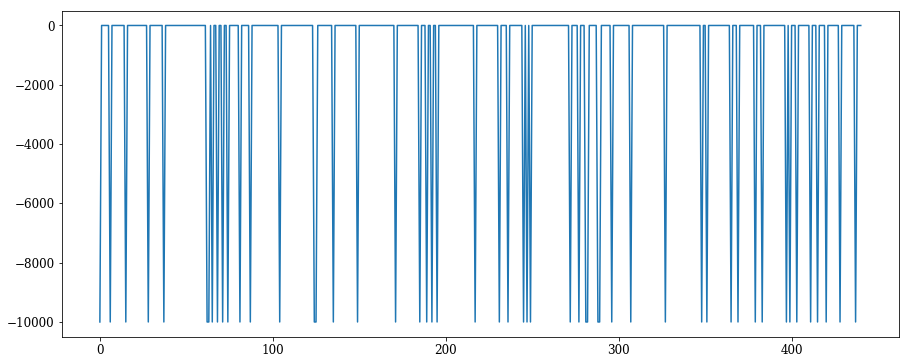

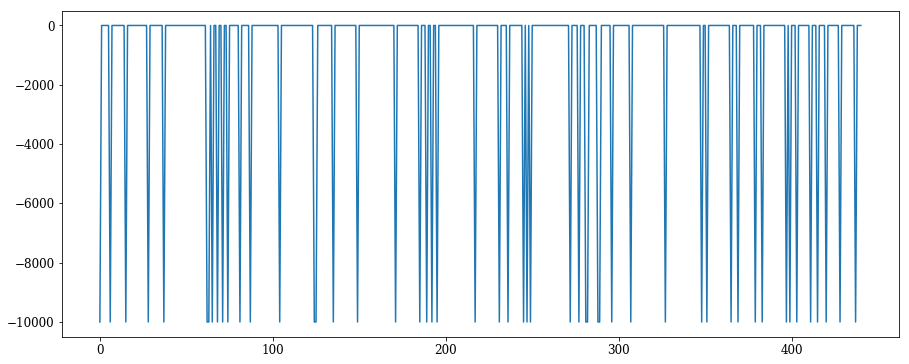

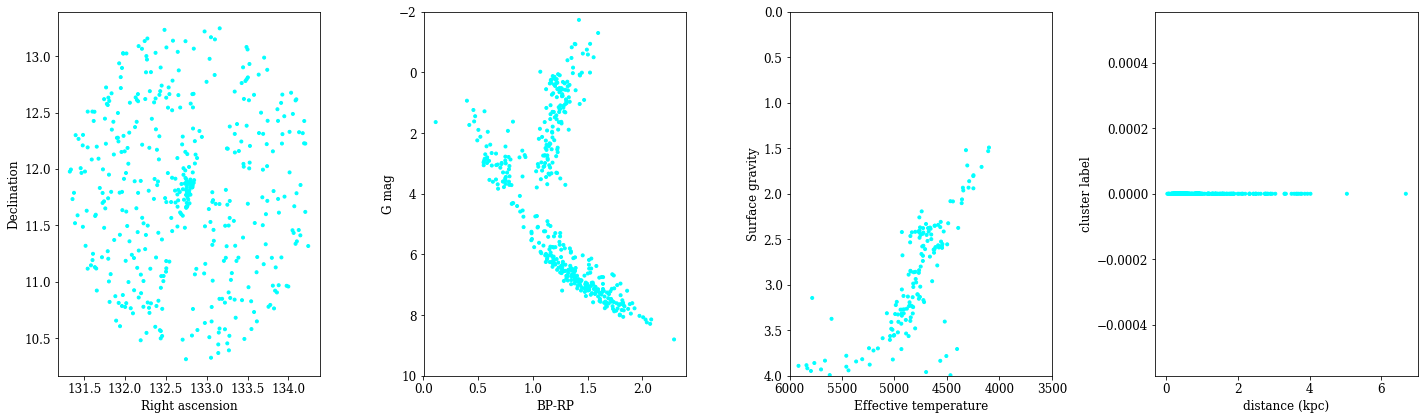

In [18]:
m67.dbscan_keys(apo,g2,radius=2*u.deg,eps=0.1,min_samples=300,gaiakeys=[],apokeys= ['C_FE', 'N_FE', 'O_FE', 'MG_FE', 
                                                                                         'AL_FE', 'SI_FE', 'K_FE', 'CA_FE',
                                                                                         'TI_FE', 'V_FE', 'CR_FE', 'MN_FE', 'FE_H', 
                                                                                         'NI_FE'],gen=False)
m67.plot_labels(lab=m67.keys_labels)

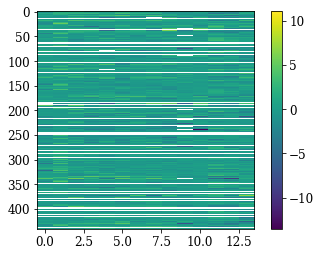

In [19]:
plt.imshow(m67.dbarray,aspect=m67.dbarray.shape[1]/float(m67.dbarray.shape[0]))
plt.colorbar()

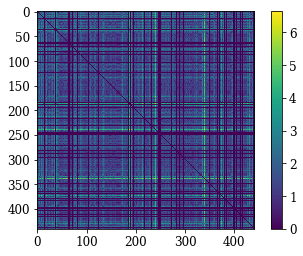

In [20]:
plt.imshow(m67.keydist)
plt.colorbar()